<a href="https://colab.research.google.com/github/gstdl/Brazilian_e-Commerce_Exploartory_Data_Analysis_and_Machine_Learning/blob/master/Brazilian_E_Commerce_EDA_%26_Cleaning_(part_1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing Libraries and Downloading Datasets.

*Please your own kaggle token to download the files on Google Colab*

In [0]:
# !pip install yellowbrick
# !pip install mlrose
# !pip install geopandas
!pip install kaggle
# !pip install --upgrade git+https://github.com/scikit-learn-contrib/hdbscan.git#egg=hdbscan
!mkdir kaggle
import json
token = {"username":"use your own username","key":"use your own key"}
with open('/content/kaggle/kaggle.json','w') as file:
  json.dump(token,file)
!mkdir ../root/.kaggle
!cp /content/kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d olistbr/brazilian-ecommerce
!unzip /content/{/content}/datasets/olistbr/brazilian-ecommerce/brazilian-ecommerce.zip

- path is now set to: {/content}
 96% 41.0M/42.7M [00:01<00:00, 15.7MB/s]
100% 42.7M/42.7M [00:01<00:00, 26.1MB/s]
Archive:  /content/{/content}/datasets/olistbr/brazilian-ecommerce/brazilian-ecommerce.zip
  inflating: olist_customers_dataset.csv  
  inflating: olist_geolocation_dataset.csv  
  inflating: olist_order_items_dataset.csv  
  inflating: olist_order_payments_dataset.csv  
  inflating: olist_order_reviews_dataset.csv  
  inflating: olist_orders_dataset.csv  
  inflating: olist_products_dataset.csv  
  inflating: olist_sellers_dataset.csv  
  inflating: product_category_name_translation.csv  


In [0]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', 999999999)
pd.set_option('display.max_rows', 999999999)


import seaborn as sns
import matplotlib.pyplot as plt
# import geopandas as gpd
%matplotlib inline

import matplotlib
matplotlib.rcParams['figure.figsize']=(24,6)
matplotlib.style.use('seaborn-whitegrid')

# import folium

import re

import pickle

def resumetable(df):
    summary = pd.DataFrame(dict(dataFeatures=df.columns,
                             dataType=df.dtypes,
                             null=df.isna().sum(),
                             nullPct=round(df.isna().sum()/len(df)*100,2),
                             unique=df.nunique(),
#                              uniqueSample=[list(df[i].drop_duplicates().sample(2)) for i in df.columns]
                            )).set_index('dataFeatures')
    
    for feature in summary.index:
        for s in ['mostValue','leastValue']:
            for i in range(3):
                if s=='leastValue':
                    j=-(1+i)
                else:
                    j=i
                try:
                    idx=df[feature].dropna().value_counts().index[j]
                    summary.loc[feature,f'{s}_{i+1}']=idx
                    summary.loc[feature,f'{s}Count_{i+1}']=df[feature].dropna().value_counts()[idx]
                except:
                    summary.loc[feature,f'{s}_{i+1}']='-'
                    summary.loc[feature,f'{s}Count_{i+1}']='-'
    return summary

In [0]:
  product_category_translate=pd.read_csv('product_category_name_translation.csv')
  dfProducts=pd.read_csv('olist_products_dataset.csv')
  dfPayments=pd.read_csv('olist_order_payments_dataset.csv')
  dfOrders=pd.read_csv('olist_orders_dataset.csv')
  dfReviews=pd.read_csv('olist_order_reviews_dataset.csv')
  dfItems=pd.read_csv('olist_order_items_dataset.csv')

In [0]:
dataframes=[x for x in dir() if 'df' in x]
dataframes

['dfItems', 'dfOrders', 'dfPayments', 'dfProducts', 'dfReviews']

In [0]:
dfs=[
     dfItems,
     dfOrders,
     dfPayments,
     dfProducts,
     dfReviews,
     ]

## EDA on Each Dataset

### Product Category Translation Dataset
#### Features in Product Category Translation Dataset

1. product_category_name = Product Category Name in Portuguese
2. product_category_name_english = Product Category Name in English

In [0]:
product_category_translate.head()

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


### Products Dataset
#### Features in Products Dataset

1. product_id = Generated ID for each product in the dataset (this feature is the primary key for dataset merging)
2. product_category_name = Category for product in the dataset
3. product_name_lenght = Quantity of letters in the name shown in product display page
4. product_description_lenght = Quantity of letters in the descriprion shown in product display page
5. product_photos_qty = Quantity of photos shown in product display page
6. product_weight_g = Weight of product in grams
7. product_length_cm = Length of product in centimeters
8. product_height_cm = Height of product in centimeters
9. product_width_cm Width of product in centimeters

In [0]:
dfProducts.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [0]:
dfProducts.shape

(32951, 9)

In [0]:
resumetable(dfProducts)

,dataType,null,nullPct,unique,mostValue_1,mostValueCount_1,mostValue_2,mostValueCount_2,mostValue_3,mostValueCount_3,leastValue_1,leastValueCount_1,leastValue_2,leastValueCount_2,leastValue_3,leastValueCount_3
dataFeatures,,,,,,,,,,,,,,,,
product_id,object,0,0.00,32951,f16d2a82f9aa7a4efd36ea25d0966c97,1.0,1336ffed1eaf9f489f9f5656f7e6fd81,1.0,14d003b4fde082d755674f43f7ceef55,1.0,212cc0fa7359ab242a697a03a574f719,1.0,a12fc4a1c79238df0015e1a0c48f0314,1.0,8509049c56caff468e3f35c4eefb6035,1.0
product_category_name,object,610,1.85,73,cama_mesa_banho,3029.0,esporte_lazer,2867.0,moveis_decoracao,2657.0,cds_dvds_musicais,1.0,seguros_e_servicos,2.0,pc_gamer,3.0
product_name_lenght,float64,610,1.85,66,60,2182.0,59,2025.0,58,1887.0,76,1.0,72,1.0,66,1.0
product_description_lenght,float64,610,1.85,2960,404,94.0,729,86.0,651,66.0,1821,1.0,2014,1.0,2872,1.0
product_photos_qty,float64,610,1.85,19,1,16489.0,2,6263.0,3,3860.0,19,1.0,20,1.0,18,2.0
product_weight_g,float64,2,0.01,2204,200,2084.0,300,1561.0,150,1259.0,22000,1.0,9660,1.0,1290,1.0
product_length_cm,float64,2,0.01,99,16,5520.0,20,2816.0,30,2029.0,7,1.0,8,2.0,9,2.0
product_height_cm,float64,2,0.01,102,10,2548.0,15,2022.0,20,1991.0,99,1.0,94,1.0,89,1.0
product_width_cm,float64,2,0.01,95,11,3718.0,20,3053.0,16,2808.0,103,1.0,118,1.0,95,1.0


In [0]:
dfProducts[~(dfProducts['product_category_name'].isin(product_category_translate['product_category_name']))].dropna()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
1628,0105b5323d24fc655f73052694dbbb3a,pc_gamer,59.0,621.0,4.0,2839.0,19.0,16.0,18.0
5821,6fd83eb3e0799b775e4f946bd66657c0,portateis_cozinha_e_preparadores_de_alimentos,52.0,280.0,1.0,1200.0,25.0,33.0,25.0
7325,5d923ead886c44b86845f69e50520c3e,portateis_cozinha_e_preparadores_de_alimentos,58.0,284.0,1.0,1200.0,25.0,33.0,25.0
7478,6727051471a0fc4a0e7737b57bff2549,pc_gamer,60.0,1532.0,3.0,650.0,16.0,22.0,20.0
8819,bed164d9d628cf0593003389c535c6e0,portateis_cozinha_e_preparadores_de_alimentos,54.0,382.0,2.0,850.0,30.0,21.0,22.0
11039,1220978a08a6b29a202bc015b18250e9,portateis_cozinha_e_preparadores_de_alimentos,46.0,280.0,1.0,1200.0,25.0,33.0,25.0
14266,ae62bb0f95af63d64eae5f93dddea8d3,portateis_cozinha_e_preparadores_de_alimentos,59.0,927.0,1.0,10600.0,40.0,20.0,38.0
16182,1954739d84629e7323a4295812a3e0ec,portateis_cozinha_e_preparadores_de_alimentos,58.0,792.0,4.0,750.0,30.0,30.0,30.0
16930,dbe520fb381ad695a7e1f2807d20c765,pc_gamer,60.0,840.0,6.0,800.0,18.0,22.0,22.0
17800,c7a3f1a7f9eef146cc499368b578b884,portateis_cozinha_e_preparadores_de_alimentos,52.0,1372.0,5.0,7350.0,40.0,30.0,23.0


*data from google translate*

| Portuguese Category Name                      | English Category Name                |
|-----------------------------------------------|--------------------------------------|
| portateis_cozinha_e_preparadores_de_alimentos | portable_cooking_and_food_prepareers |
| pc_gamer                                      | pc_gamer                             |

In [0]:
translate_name={'portateis_cozinha_e_preparadores_de_alimentos' : 'portable_cooking_and_food_prepareers',
                'pc_gamer':'pc_gamer',
                **{i:j for i,j in zip(product_category_translate.iloc[:,0]
                                     ,product_category_translate.iloc[:,1])}}

dfProducts['product_category_name'].replace(translate_name,inplace=True)

dfProducts.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumery,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,art,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,sports_leisure,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,baby,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,housewares,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [0]:
for i in dfProducts['product_category_name'].dropna():
    if i not in translate_name.values():
        print(i)
print('done searching')

done searching


In [0]:
def underscore_to_space(x):
    if pd.isna(x):
        return x
    else:
        return re.sub(r'_',' ',x)
dfProducts['product_category_name']=dfProducts['product_category_name'].apply(underscore_to_space)
dfProducts.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumery,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,art,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,sports leisure,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,baby,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,housewares,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [0]:
resumetable(dfProducts)

,dataType,null,nullPct,unique,mostValue_1,mostValueCount_1,mostValue_2,mostValueCount_2,mostValue_3,mostValueCount_3,leastValue_1,leastValueCount_1,leastValue_2,leastValueCount_2,leastValue_3,leastValueCount_3
dataFeatures,,,,,,,,,,,,,,,,
product_id,object,0,0.00,32951,f16d2a82f9aa7a4efd36ea25d0966c97,1.0,1336ffed1eaf9f489f9f5656f7e6fd81,1.0,14d003b4fde082d755674f43f7ceef55,1.0,212cc0fa7359ab242a697a03a574f719,1.0,a12fc4a1c79238df0015e1a0c48f0314,1.0,8509049c56caff468e3f35c4eefb6035,1.0
product_category_name,object,610,1.85,73,bed bath table,3029.0,sports leisure,2867.0,furniture decor,2657.0,cds dvds musicals,1.0,security and services,2.0,pc gamer,3.0
product_name_lenght,float64,610,1.85,66,60,2182.0,59,2025.0,58,1887.0,76,1.0,72,1.0,66,1.0
product_description_lenght,float64,610,1.85,2960,404,94.0,729,86.0,651,66.0,1821,1.0,2014,1.0,2872,1.0
product_photos_qty,float64,610,1.85,19,1,16489.0,2,6263.0,3,3860.0,19,1.0,20,1.0,18,2.0
product_weight_g,float64,2,0.01,2204,200,2084.0,300,1561.0,150,1259.0,22000,1.0,9660,1.0,1290,1.0
product_length_cm,float64,2,0.01,99,16,5520.0,20,2816.0,30,2029.0,7,1.0,8,2.0,9,2.0
product_height_cm,float64,2,0.01,102,10,2548.0,15,2022.0,20,1991.0,99,1.0,94,1.0,89,1.0
product_width_cm,float64,2,0.01,95,11,3718.0,20,3053.0,16,2808.0,103,1.0,118,1.0,95,1.0


In [0]:
dfProducts[dfProducts['product_category_name'].isna()].isna().sum()

product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                1
product_length_cm               1
product_height_cm               1
product_width_cm                1
dtype: int64

In [0]:
dfProducts[dfProducts['product_weight_g'].isna()]

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
8578,09ff539a621711667c43eba6a3bd8466,baby,60.0,865.0,3.0,NaN,NaN,NaN,NaN
18851,5eb564652db742ff8f28759cd8d2652a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
dfProducts[dfProducts['product_category_name']=='baby'].describe().T

,count,mean,std,min,25%,50%,75%,max
product_name_lenght,919.0,46.056583,11.382298,7.0,38.0,49.0,55.50,64.0
product_description_lenght,919.0,824.261153,544.414530,4.0,381.0,728.0,1133.00,3923.0
product_photos_qty,919.0,2.352557,1.735121,1.0,1.0,2.0,3.00,19.0
product_weight_g,918.0,3655.201525,5665.129577,50.0,400.0,850.0,5106.25,30000.0
product_length_cm,918.0,37.147059,17.945730,14.0,23.0,33.0,45.00,102.0
product_height_cm,918.0,21.617647,16.591138,2.0,10.0,16.0,30.00,97.0
product_width_cm,918.0,28.717865,13.964589,8.0,16.0,25.0,40.00,84.0


In [0]:
dfProducts[dfProducts['product_category_name']=='baby']['product_width_cm'].median()

25.0

In [0]:
# fig,axes=plt.subplots(2,4,figsize=(24,6*2))
# for func,axe in zip(['box','dist'],axes):
#     for col, ax in zip(dfProducts.iloc[:,-4:],axe):
#         ser=dfProducts[dfProducts['product_category_name']=='baby'][col].dropna()
#         if func=='dist':
#             sns.distplot(ser,ax=ax,)
#         if func=='box':
#             sns.boxplot(ser,ax=ax)

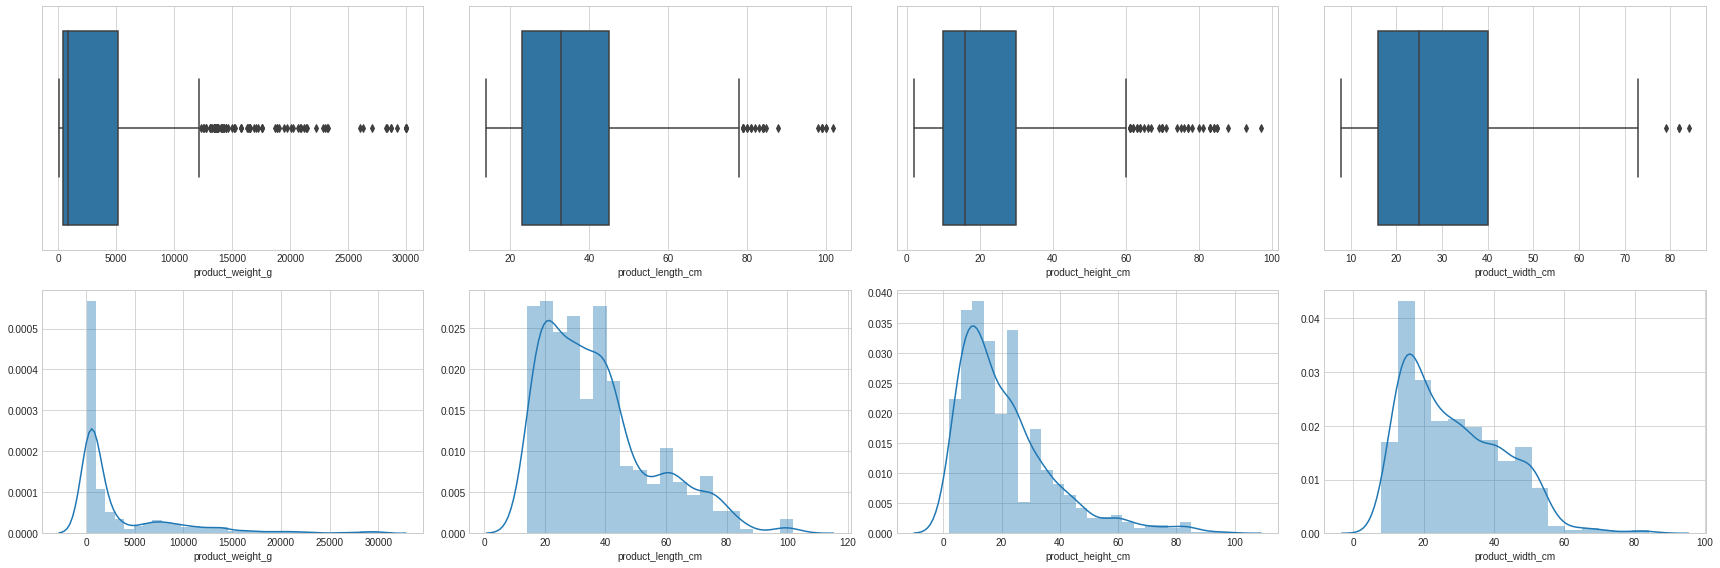

In [0]:
fig,axes=plt.subplots(2,4,figsize=(24,4*2))
for func,axe in zip([sns.boxplot,sns.distplot],axes):
    for col, ax in zip(dfProducts.columns[-4:],axe):
        ser=dfProducts[dfProducts['product_category_name']=='baby'][col].dropna()
        func(ser,ax=ax,)
plt.tight_layout()

In [0]:
baby_modes=dfProducts[dfProducts['product_category_name']=='baby'].iloc[:,-4:].mode()
baby_modes={col:baby_modes.loc[0,col] for col in baby_modes}
baby_modes

{'product_height_cm': 25.0,
 'product_length_cm': 20.0,
 'product_weight_g': 200.0,
 'product_width_cm': 15.0}

In [0]:
dfProducts.iloc[8578]

product_id                    09ff539a621711667c43eba6a3bd8466
product_category_name                                     baby
product_name_lenght                                         60
product_description_lenght                                 865
product_photos_qty                                           3
product_weight_g                                           NaN
product_length_cm                                          NaN
product_height_cm                                          NaN
product_width_cm                                           NaN
Name: 8578, dtype: object

In [0]:
dfProducts[dfProducts['product_category_name']=='baby']=dfProducts[dfProducts['product_category_name']=='baby'].fillna(baby_modes)
dfProducts[dfProducts['product_weight_g'].isna()]

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
18851,5eb564652db742ff8f28759cd8d2652a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
dfProducts.iloc[8578]

product_id                    09ff539a621711667c43eba6a3bd8466
product_category_name                                     baby
product_name_lenght                                         60
product_description_lenght                                 865
product_photos_qty                                           3
product_weight_g                                           200
product_length_cm                                           20
product_height_cm                                           25
product_width_cm                                            15
Name: 8578, dtype: object

In [0]:
dfProducts.describe(exclude='number')

,product_id,product_category_name
count,32951,32341
unique,32951,73
top,f16d2a82f9aa7a4efd36ea25d0966c97,bed bath table
freq,1,3029


(0, 3500)

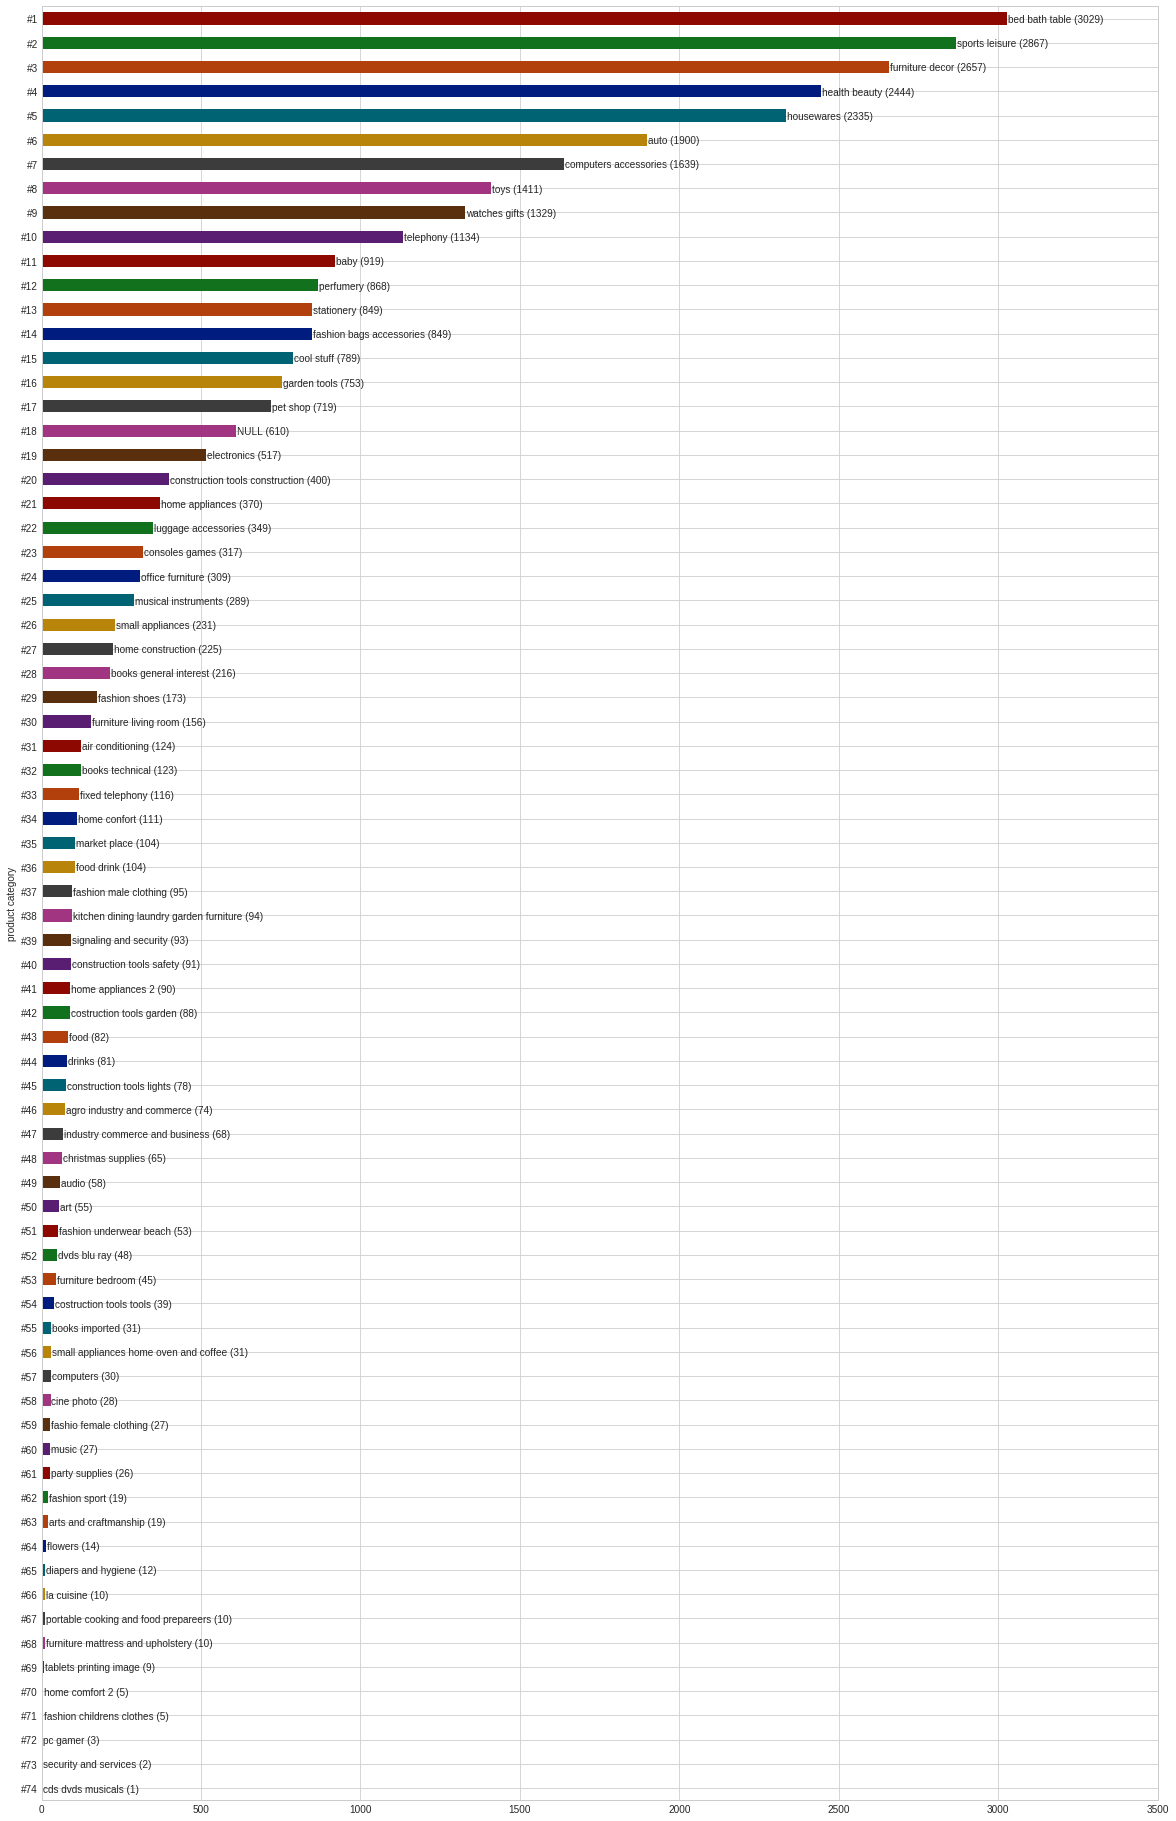

In [0]:
ser=dfProducts['product_category_name'].fillna('NULL').value_counts(ascending=True)
ser.plot.barh(figsize=(20,33),color=sns.color_palette('dark'))

for y,x in enumerate(ser.index):
    plt.annotate(f'{x} ({ser[x]})', (ser[x]+3,y-0.15))
plt.yticks(range(y+1),[f'#{i}' for i in range(y+1,0,-1)])
plt.ylabel('product category')
plt.xlim(0,3500)

Total unique values in product_category_name feature is 74


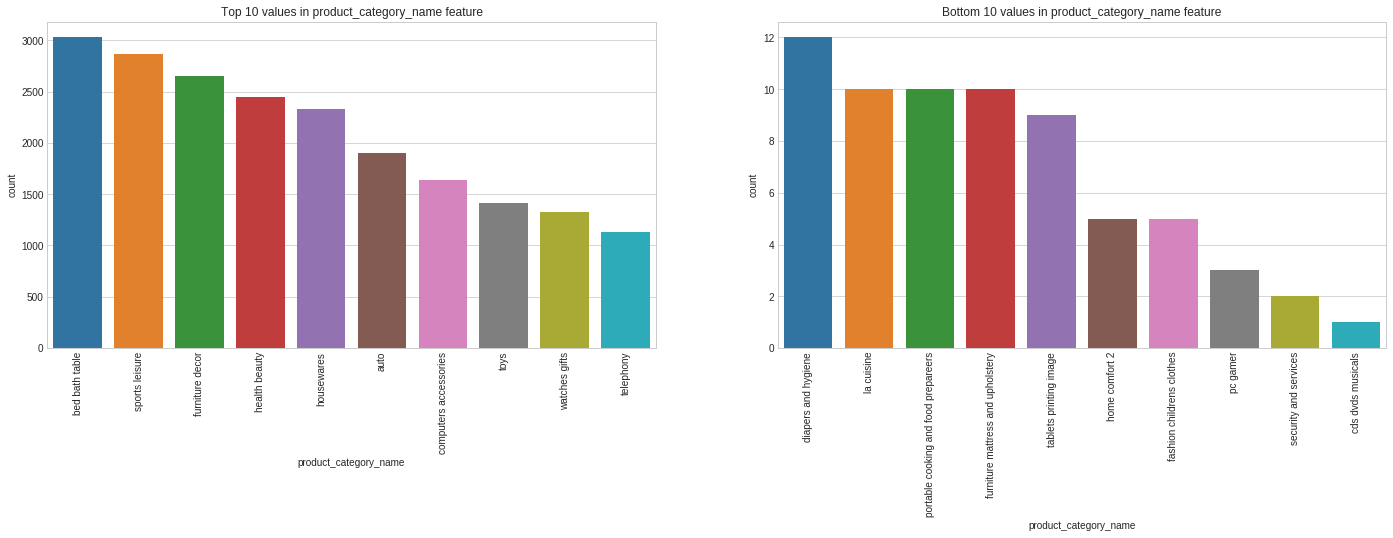

In [0]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(24,6))
ser=dfProducts['product_category_name'].fillna('NULL')
sns.countplot(ser,ax=ax1,order=ser.value_counts().head(10).index)
ax1.tick_params('x',labelrotation=90)
ax1.set_title('Top 10 values in product_category_name feature')
sns.countplot(ser,ax=ax2,order=ser.value_counts().tail(10).index)
ax2.tick_params('x',labelrotation=90)
ax2.set_title('Bottom 10 values in product_category_name feature')
print('Total unique values in product_category_name feature is %s'%(ser.nunique()))

In [0]:
dfProducts[dfProducts['product_category_name'].isin(['bed bath table','cool stuff','home appliances','home appliances 2'])].groupby('product_category_name').describe().T

product_category_name             bed bath table    cool stuff  \
product_name_lenght        count     3029.000000    789.000000   
                           mean        51.728293     47.574144   
                           std          7.646314     10.375495   
                           min         16.000000     11.000000   
                           25%         49.000000     41.000000   
                           50%         54.000000     51.000000   
                           75%         57.000000     56.000000   
                           max         68.000000     64.000000   
product_description_lenght count     3029.000000    789.000000   
                           mean       464.483328    876.125475   
                           std        385.235244    641.297108   
                           min         58.000000     66.000000   
                           25%        236.000000    422.000000   
                           50%        365.000000    733.000000   
                           75%        609.000000   1049.000000   
                           max       3863.000000   3976.000000   
product_photos_qty         count     3029.000000    789.000000   
                           mean         1.392539      2.278834   
                           std          0.874992      1.660475   
                           min          1.000000      1.000000   
                           25%          1.000000      1.000000   
                           50%          1.000000      2.000000   
                           75%          1.000000      3.000000   
                           max          9.000000     13.000000   
product_weight_g           count     3029.000000    789.000000   
                           mean      2456.405084   2566.579214   
                           std       3732.667484   4249.997509   
                           min          0.000000     50.000000   
                           25%        700.000000    500.000000   
                           50%       1250.000000   1100.000000   
                           75%       2300.000000   2200.000000   
                           max      40425.000000  30000.000000   
product_length_cm          count     3029.000000    789.000000   
                           mean        36.774183     33.752852   
                           std         13.680511     16.647007   
                           min         12.000000     12.000000   
                           25%         28.000000     20.000000   
                           50%         37.000000     30.000000   
                           75%         45.000000     42.000000   
                           max        105.000000    105.000000   
product_height_cm          count     3029.000000    789.000000   
                           mean        14.091119     22.988593   
                           std          9.628311     15.382554   
                           min          2.000000      2.000000   
                           25%          8.000000     11.000000   
                           50%         11.000000     20.000000   
                           75%         17.000000     30.000000   
                           max         93.000000     98.000000   
product_width_cm           count     3029.000000    789.000000   
                           mean        30.589964     24.491762   
                           std         11.182182     11.955140   
                           min          7.000000     11.000000   
                           25%         22.000000     15.000000   
                           50%         30.000000     21.000000   
                           75%         37.000000     30.000000   
                           max        118.000000    105.000000   

product_category_name             home appliances  home appliances 2  
product_name_lenght        count       370.000000          90.000000  
                           mean         54.481081          48.377778  
                        

In [0]:
dfProducts.describe()

,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
count,32341.000000,32341.000000,32341.000000,32950.000000,32950.000000,32950.000000,32950.000000
mean,48.476949,771.495285,2.188986,2276.409469,30.814750,16.937906,23.196480
std,10.245741,635.115225,1.736766,4281.989031,16.914306,13.637419,12.078949
min,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000
25%,42.000000,339.000000,1.000000,300.000000,18.000000,8.000000,15.000000
50%,51.000000,595.000000,1.000000,700.000000,25.000000,13.000000,20.000000
75%,57.000000,972.000000,3.000000,1900.000000,38.000000,21.000000,30.000000
max,76.000000,3992.000000,20.000000,40425.000000,105.000000,105.000000,118.000000


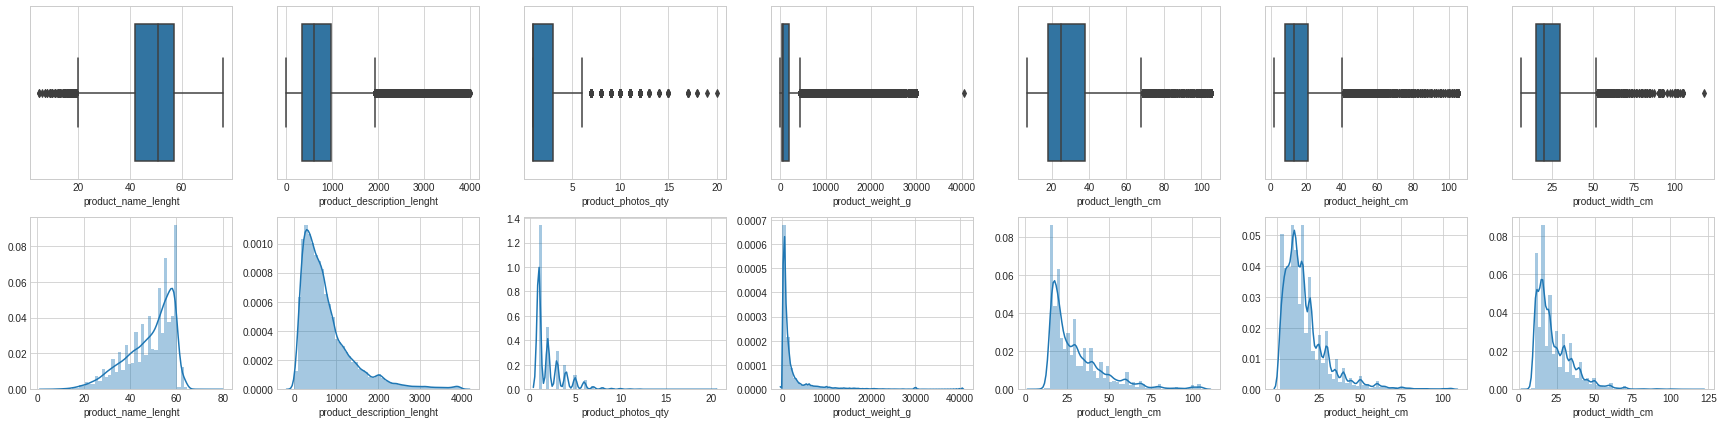

In [0]:
cols=dfProducts.columns[2:]
fig,axes=plt.subplots(2,7,figsize=(24,3*2))
for func,axe in zip([sns.boxplot,sns.distplot],axes):
    for col, ax in zip(cols,axe):
        ser=dfProducts[col].dropna()
        func(ser,ax=ax,)
plt.tight_layout()

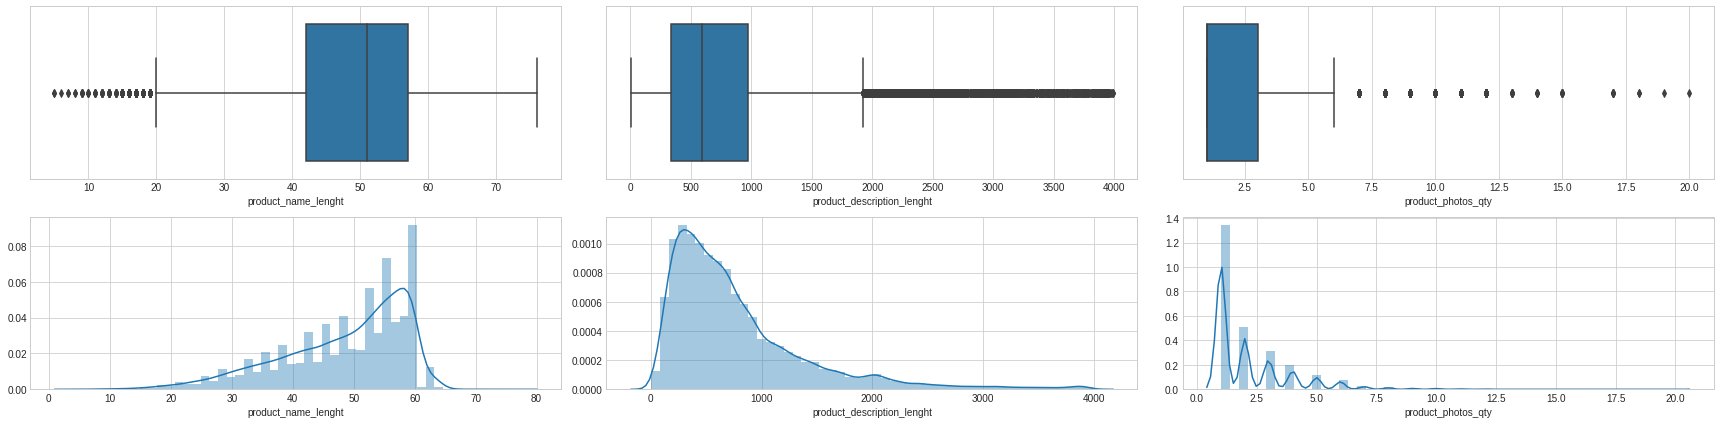

In [0]:
cols=dfProducts.columns[2:5]
fig,axes=plt.subplots(2,3,figsize=(24,3*2))
for func,axe in zip([sns.boxplot,sns.distplot],axes):
    for col, ax in zip(cols,axe):
        ser=dfProducts[col].dropna()
        func(ser,ax=ax,)
plt.tight_layout()

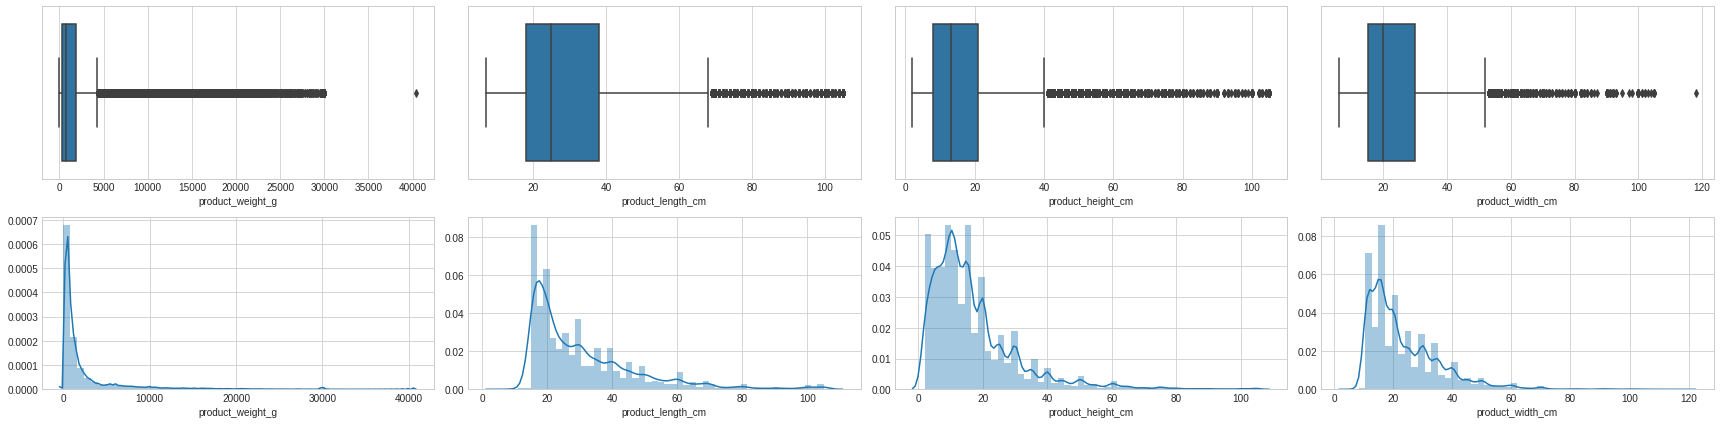

In [0]:
cols=dfProducts.columns[5:]
fig,axes=plt.subplots(2,4,figsize=(24,3*2))
for func,axe in zip([sns.boxplot,sns.distplot],axes):
    for col, ax in zip(cols,axe):
        ser=dfProducts[col].dropna()
        func(ser,ax=ax,)
plt.tight_layout()

In [0]:
dfProducts[pd.isna(dfProducts['product_category_name'])].describe()

,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
count,0.0,0.0,0.0,609.000000,609.000000,609.000000,609.000000
mean,NaN,NaN,NaN,2250.765189,28.719212,15.814450,22.566502
std,NaN,NaN,NaN,4429.016600,14.398293,13.678043,12.087371
min,NaN,NaN,NaN,50.000000,15.000000,2.000000,11.000000
25%,NaN,NaN,NaN,250.000000,16.000000,5.000000,13.000000
50%,NaN,NaN,NaN,700.000000,25.000000,12.000000,20.000000
75%,NaN,NaN,NaN,1683.000000,35.000000,22.000000,30.000000
max,NaN,NaN,NaN,30000.000000,105.000000,92.000000,80.000000


#### Cleaning
1. Renamed data in product_category_name feature from Portuguese to English by using the dataset provided by OLIST and Google Translate
2. Replaced underscores in product_category_name with whitespace
3. Filled a few NaN values in the dataset

#### Interesting Insights

1. 620 product in the dataset has missing values in product category name, product name length, and product photos quantity features for an unknown reason. One of them has no known value except for product ID, while the other 619 has information about their weight and dimension.

*Developing a classifier might fill the missing values*

2. The most bought product category in the dataset are bed bath table, sports leisure, and furniture decore with cd dvds musical, security and services, and pc gamer as the least bought product.

3. The products with missing value product category name has similar weight and dimension compared to the weight and dimension in the dataset.

*Clasifying the products category into the remaining product category names might be very challenging with the features available in this dataframe.*

### Payments Dataset
#### Features in Payments Dataset

1. order_id = Generated ID for each payment in the dataset (this feature is the primary key for dataset merging)
2. payment_sequential = Sequence of payment counts made by a particular order_id
3. payment_type = Method of payment
4. payment_installmant = Intallments made for the corresponding order_id
5. payment_value = Quantity payed for the corresponding order_id

In [0]:
dfPayments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [0]:
dfPayments.shape

(103886, 5)

In [0]:
resumetable(dfPayments).T

dataFeatures,order_id,payment_sequential,payment_type,payment_installments,payment_value
dataType,object,int64,object,int64,float64
null,0,0,0,0,0
nullPct,0,0,0,0,0
unique,99440,29,5,24,29077
mostValue_1,fa65dad1b0e818e3ccc5cb0e39231352,1,credit_card,1,50
mostValueCount_1,29,99360,76795,52546,324
mostValue_2,ccf804e764ed5650cd8759557269dc13,2,boleto,2,20
mostValueCount_2,26,3039,19784,12413,274
mostValue_3,285c2e15bebd4ac83635ccc563dc71f4,3,voucher,3,100
mostValueCount_3,22,581,5775,10461,255


In [0]:
103886-99440

4446

**What is Boleto?**

Boleto Bancário, simply referred to as Boleto (English: Ticket) is a payment method in Brazil regulated by FEBRABAN, short for Brazilian Federation of Banks.

A boleto can be paid at ATMs, branch facilities and internet banking of any Bank, Post Office, Lottery Agent and some supermarkets until its due date. After the due date it can only be paid at the issuer bank facilities.

Boleto can only be collected by an authorized Collector Agent in the Brazilian territory.[citation needed] All Brazilian banks, Post Offices (Correios) and Lottery Agencies plus some companies from the private sector have joined the system.[1]

*source: https://en.wikipedia.org/wiki/Boleto*

In [0]:
dfPayments.describe(include='all')

,order_id,payment_sequential,payment_type,payment_installments,payment_value
count,103886,103886.000000,103886,103886.000000,103886.000000
unique,99440,NaN,5,NaN,NaN
top,fa65dad1b0e818e3ccc5cb0e39231352,NaN,credit_card,NaN,NaN
freq,29,NaN,76795,NaN,NaN
mean,NaN,1.092679,NaN,2.853349,154.100380
std,NaN,0.706584,NaN,2.687051,217.494064
min,NaN,1.000000,NaN,0.000000,0.000000
25%,NaN,1.000000,NaN,1.000000,56.790000
50%,NaN,1.000000,NaN,1.000000,100.000000
75%,NaN,1.000000,NaN,4.000000,171.837500


duplicate order_id in dfPayment = 2961 (2.98%)
total duplicate order_id in dfPayment = 7407 (0.07%)


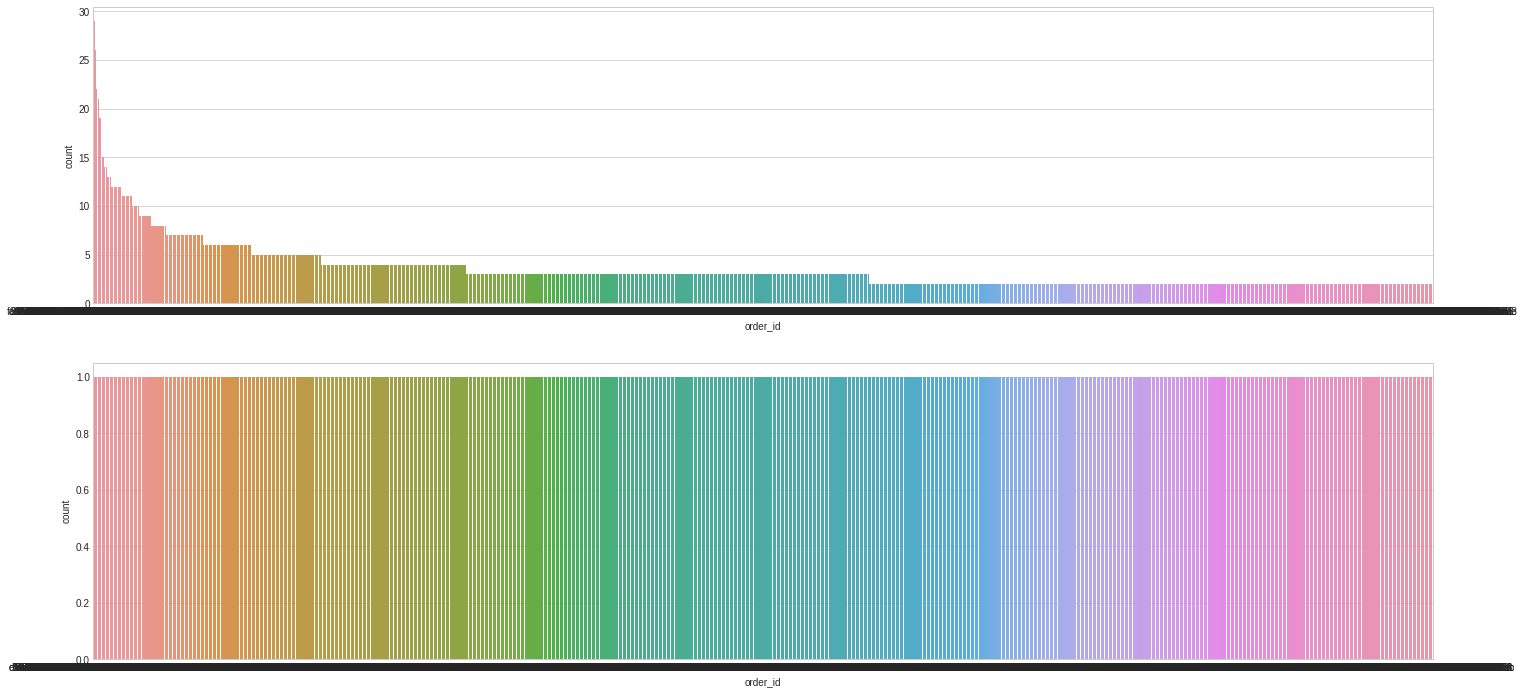

In [0]:
order_id_more_than_1=dfPayments['order_id'].value_counts()[dfPayments['order_id'].value_counts()>1]
print('duplicate order_id in dfPayment = {} ({}%)'.format(len(order_id_more_than_1),round(len(order_id_more_than_1)/dfPayments['order_id'].nunique()*100,2)))
print('total duplicate order_id in dfPayment = {} ({}%)'.format(order_id_more_than_1.sum(),round(order_id_more_than_1.sum()/len(dfPayments),2)))
fig,axes=plt.subplots(2,1,figsize=(24,12))
sns.countplot(dfPayments['order_id'],order=dfPayments['order_id'].value_counts().head(1000).index,ax=axes[0])
sns.countplot(dfPayments['order_id'],order=dfPayments['order_id'].value_counts().tail(1000).index,ax=axes[1])

In [0]:
order_id_more_than_1

fa65dad1b0e818e3ccc5cb0e39231352    29
ccf804e764ed5650cd8759557269dc13    26
285c2e15bebd4ac83635ccc563dc71f4    22
895ab968e7bb0d5659d16cd74cd1650c    21
fedcd9f7ccdc8cba3a18defedd1a5547    19
ee9ca989fc93ba09a6eddc250ce01742    19
4bfcba9e084f46c8e3cb49b0fa6e6159    15
21577126c19bf11a0b91592e5844ba78    15
4689b1816de42507a7d63a4617383c59    14
3c58bffb70dcf45f12bdf66a3c215905    14
cf101c3abd3c061ca9f78c1bbb1125af    13
73df5d6adbeea12c8ae03df93f346e86    13
4fb76fa13b108a0d0478483421b0992c    13
465c2e1bee4561cb39e0db8c5993aafc    12
1d9a9731b9c10fc9cba74e6f74782e8b    12
68986e4324f6a21481df4e6e89abcf01    12
6d58638e32674bebee793a47ac4cbadc    12
67d83bd36ec2c7fb557742fb58837659    12
d744783ed2ace06cac647a9e64dcbcfd    12
c6492b842ac190db807c15aff21a7dd6    12
1a611328643ae11146ba09a4425d2e12    12
27a940efdd448db29463b53ea0cfa2f4    11
654da57158d96035814657b5143bb11b    11
1be51feefcd481bee3118900e6777057    11
370e2e6c1a9fd451eb7f0852daa3b006    11
4069c489933782af79afcd3a0

In [0]:
ln=dfPayments[
    (dfPayments['order_id'].isin((dfPayments['order_id'].value_counts()[dfPayments['order_id'].value_counts()==29]).index))
].sort_values('payment_sequential')
print(len(ln))
ln

29


,order_id,payment_sequential,payment_type,payment_installments,payment_value
14321,fa65dad1b0e818e3ccc5cb0e39231352,1,voucher,1,3.71
23074,fa65dad1b0e818e3ccc5cb0e39231352,2,voucher,1,8.51
65641,fa65dad1b0e818e3ccc5cb0e39231352,3,voucher,1,2.95
9985,fa65dad1b0e818e3ccc5cb0e39231352,4,voucher,1,29.16
28330,fa65dad1b0e818e3ccc5cb0e39231352,5,voucher,1,0.66
29648,fa65dad1b0e818e3ccc5cb0e39231352,6,voucher,1,5.02
82593,fa65dad1b0e818e3ccc5cb0e39231352,7,voucher,1,0.32
68853,fa65dad1b0e818e3ccc5cb0e39231352,8,voucher,1,26.02
17274,fa65dad1b0e818e3ccc5cb0e39231352,9,voucher,1,1.08
19565,fa65dad1b0e818e3ccc5cb0e39231352,10,voucher,1,12.86


In [0]:
ln=dfPayments[
    (dfPayments['order_id'].isin((dfPayments['order_id'].value_counts()[dfPayments['order_id'].value_counts()==26]).index))
].sort_values('payment_sequential')
print(len(ln))
ln

26


,order_id,payment_sequential,payment_type,payment_installments,payment_value
14362,ccf804e764ed5650cd8759557269dc13,1,credit_card,1,2.20
38001,ccf804e764ed5650cd8759557269dc13,2,voucher,1,1.45
40387,ccf804e764ed5650cd8759557269dc13,3,voucher,1,1.15
95153,ccf804e764ed5650cd8759557269dc13,4,voucher,1,0.99
40369,ccf804e764ed5650cd8759557269dc13,5,voucher,1,2.69
21447,ccf804e764ed5650cd8759557269dc13,6,voucher,1,2.26
41414,ccf804e764ed5650cd8759557269dc13,7,voucher,1,1.60
79324,ccf804e764ed5650cd8759557269dc13,8,voucher,1,2.42
87981,ccf804e764ed5650cd8759557269dc13,9,voucher,1,0.97
71309,ccf804e764ed5650cd8759557269dc13,10,voucher,1,1.20


In [0]:
ln=dfPayments[
    (dfPayments['order_id'].isin((dfPayments['order_id'].value_counts()[dfPayments['order_id'].value_counts()==19]).index))
].sort_values(['payment_sequential','order_id'])
print(len(ln))
ln

38


,order_id,payment_sequential,payment_type,payment_installments,payment_value
8910,ee9ca989fc93ba09a6eddc250ce01742,1,credit_card,1,1.76
9665,fedcd9f7ccdc8cba3a18defedd1a5547,1,credit_card,1,1.67
52343,ee9ca989fc93ba09a6eddc250ce01742,2,voucher,1,5.88
27087,fedcd9f7ccdc8cba3a18defedd1a5547,2,voucher,1,7.76
35428,ee9ca989fc93ba09a6eddc250ce01742,3,voucher,1,12.49
87783,fedcd9f7ccdc8cba3a18defedd1a5547,3,voucher,1,26.94
64576,ee9ca989fc93ba09a6eddc250ce01742,4,voucher,1,3.49
45197,fedcd9f7ccdc8cba3a18defedd1a5547,4,voucher,1,10.33
68844,ee9ca989fc93ba09a6eddc250ce01742,5,voucher,1,3.58
36869,fedcd9f7ccdc8cba3a18defedd1a5547,5,voucher,1,9.76


In [0]:
for i in dfPayments['payment_sequential'].unique():
    if len(dfPayments[dfPayments['payment_sequential']==i]['order_id'])==len(dfPayments[dfPayments['payment_sequential']==i]):
        print(f'"payment_sequential = {i}" has the same length')
    else:
        print(f'"payment_sequential = {i}" does not has the same length')
ln=[len(dfPayments[dfPayments['payment_sequential']==i]) for i in range(1,30)]
pd.DataFrame({'payment_sequential':[*range(1,30),'sum'],'Total Orders':[*ln,sum(ln)]})

"payment_sequential = 1" has the same length
"payment_sequential = 2" has the same length
"payment_sequential = 4" has the same length
"payment_sequential = 5" has the same length
"payment_sequential = 3" has the same length
"payment_sequential = 8" has the same length
"payment_sequential = 6" has the same length
"payment_sequential = 7" has the same length
"payment_sequential = 10" has the same length
"payment_sequential = 11" has the same length
"payment_sequential = 17" has the same length
"payment_sequential = 19" has the same length
"payment_sequential = 27" has the same length
"payment_sequential = 12" has the same length
"payment_sequential = 9" has the same length
"payment_sequential = 15" has the same length
"payment_sequential = 13" has the same length
"payment_sequential = 14" has the same length
"payment_sequential = 16" has the same length
"payment_sequential = 25" has the same length
"payment_sequential = 22" has the same length
"payment_sequential = 26" has the same leng

,payment_sequential,Total Orders
0,1,99360
1,2,3039
2,3,581
3,4,278
4,5,170
5,6,118
6,7,82
7,8,54
8,9,43
9,10,34


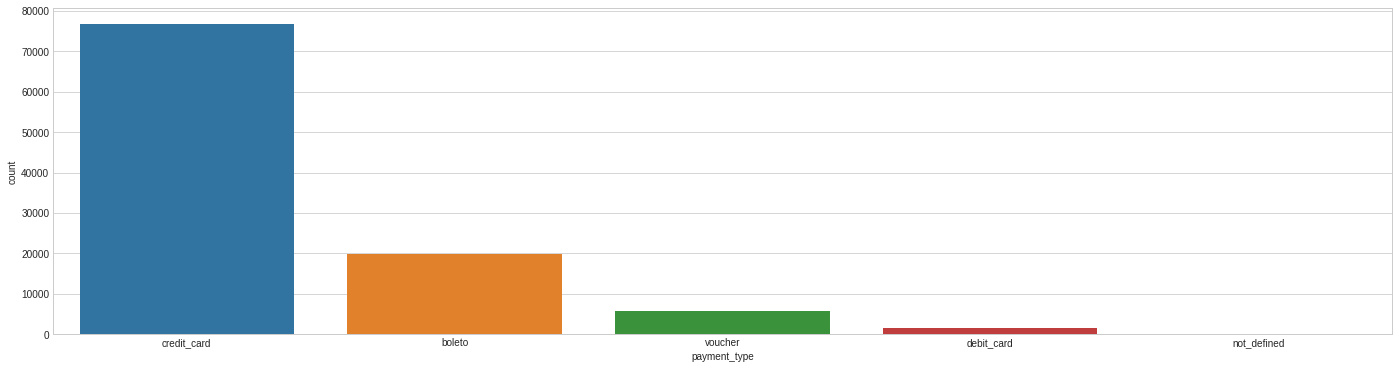

In [0]:
sns.countplot(dfPayments['payment_type'])

In [0]:
gb=dfPayments.groupby('payment_type')['payment_value'].describe()
gb['sum']=dfPayments.groupby('payment_type')['payment_value'].agg(['sum'])
gb

,count,mean,std,min,25%,50%,75%,max,sum
payment_type,,,,,,,,,
boleto,19784.0,145.034435,213.581061,11.62,55.5225,93.89,160.7625,7274.88,2.869361e+06
credit_card,76795.0,163.319021,222.119311,0.01,62.2100,106.87,181.2100,13664.08,1.254208e+07
debit_card,1529.0,142.570170,245.793401,13.38,51.1000,89.30,154.3200,4445.50,2.179898e+05
not_defined,3.0,0.000000,0.000000,0.00,0.0000,0.00,0.0000,0.00,0.000000e+00
voucher,5775.0,65.703354,115.519185,0.00,18.0350,39.28,80.0000,3184.34,3.794369e+05


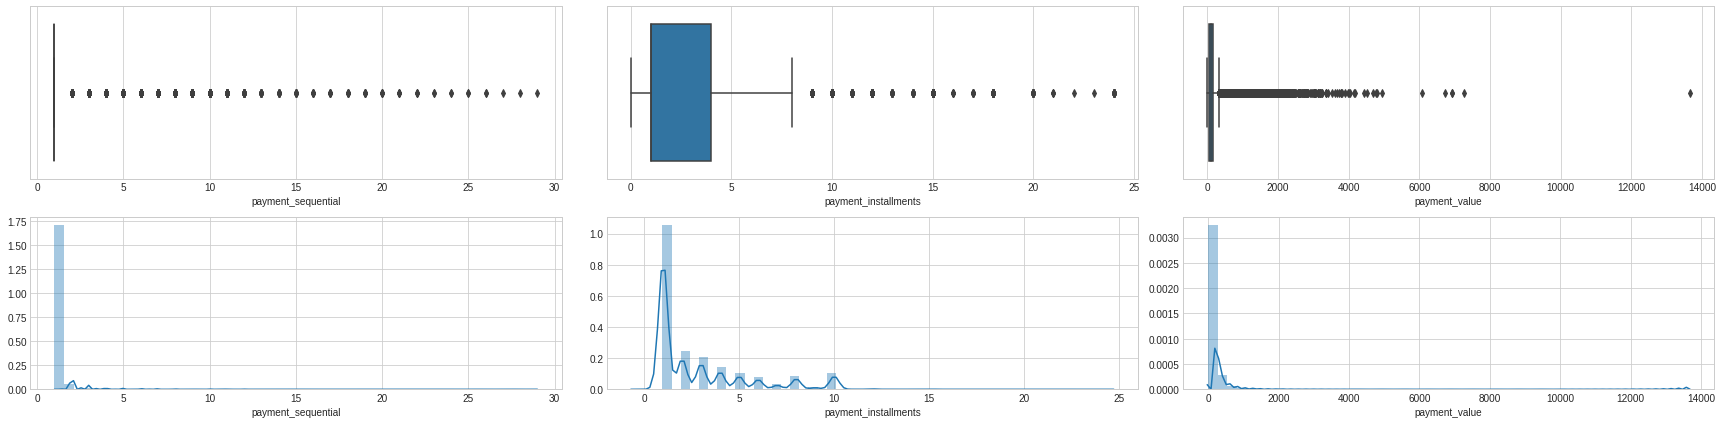

In [0]:
fig,axes=plt.subplots(2,3,figsize=(24,3*2))
for func,axe in zip([sns.boxplot,sns.distplot],axes):
    for col, ax in zip(['payment_sequential','payment_installments','payment_value'],axe):
        ser=dfPayments[col]
        func(ser,ax=ax,)
plt.tight_layout()

In [0]:
gb_dfPayments=dfPayments.groupby('order_id').max()['payment_sequential']
gb_dfPayments={i:gb_dfPayments[i] for i in dfPayments['order_id'].unique()}
dfPayments1=dfPayments.copy()
dfPayments1['total_sequential']=dfPayments['order_id'].map(gb_dfPayments)
dfPayments1.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value,total_sequential
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33,1
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39,1
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71,1
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78,1
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45,1


In [0]:
dfPayments1.groupby('total_sequential').agg(['sum','mean','std','min','max','count'])

payment_sequential                                      \
                                sum       mean       std min max  count   
total_sequential                                                          
1                             96401   1.000000  0.000000   1   1  96401   
2                              7296   1.508061  0.499987   1   2   4838   
3                              1816   2.002205  0.816494   1   3    907   
4                              1080   2.500000  1.119330   1   4    432   
5                               780   3.000000  1.416941   1   5    260   
6                               756   3.500000  1.711792   1   6    216   
7                               784   4.000000  2.005122   1   7    196   
8                               396   4.500000  2.304419   1   8     88   
9                               405   5.000000  2.598076   1   9     81   
10                              275   5.500000  2.901442   1  10     50   
11                              528   6.000000  3.180400   1  11     88   
12                              624   6.500000  3.470174   1  12     96   
13                              273   7.000000  3.790570   1  13     39   
14                              210   7.500000  4.105101   1  14     28   
15                              240   8.000000  4.394354   1  15     30   
19                              380  10.000000  5.550749   1  19     38   
21                              231  11.000000  6.204837   1  21     21   
22                              253  11.500000  6.493587   1  22     22   
26                              351  13.500000  7.648529   1  26     26   
29                              435  15.000000  8.514693   1  29     29   

                 payment_installments                                     \
                                  sum      mean       std min max  count   
total_sequential                                                           
1                              284650  2.952770  2.720530   1  24  96401   
2                                8870  1.833402  2.095494   0  24   4838   
3                                1083  1.194046  0.986581   1  10    907   
4                                 465  1.076389  0.519859   1   6    432   
5                                 273  1.050000  0.528530   1   9    260   
6                                 230  1.064815  0.447695   1   6    216   
7                                 203  1.035714  0.255704   1   3    196   
8                                  88  1.000000  0.000000   1   1     88   
9                                  82  1.012346  0.111111   1   2     81   
10                                 50  1.000000  0.000000   1   1     50   
11                                 94  1.068182  0.639602   1   7     88   
12                                102  1.062500  0.454510   1   5     96   
13                                 39  1.000000  0.000000   1   1     39   
14                                 28  1.000000  0.000000   1   1     28   
15                                 30  1.000000  0.000000   1   1     30   
19                                 38  1.000000  0.000000   1   1     38   
21                                 21  1.000000  0.000000   1   1     21   
22                                 22  1.000000  0.000000   1   1     22   
26                                 26  1.000000  0.000000   1   1     26   
29                                 29  1.000000  0.000000   1   1     29   

                 payment_value                                                 
                           sum        mean         std   min       max  count  
total_sequential                                                               
1                 1.550352e+07  160.823221  221.044382  0.00  13664.08  96401  
2                 4.263500e+05   88.125267  165.026859  0.01   3899.00   4838  
3                 3.822273e+04   42.141929   59.631829  0.00    682.97    907  
4                 1.117330e+04   25.864120   28.880983  0.00  

In [0]:
dfPayments1.groupby('total_sequential').describe(exclude='number')

order_id                                                \
                    count unique                               top freq   
total_sequential                                                          
1                   96401  96401  dd0710bca2d815cf18148d1d9859fb3b    1   
2                    4838   2458  555e1afa0cf180760b7ea9f6d8ebc329    2   
3                     907    303  f1cefe8e64d1771be13b8fd8360385e3    3   
4                     432    108  1cb44c843df038496648b84a904aafa6    4   
5                     260     52  e47a63ad65b54953702eae37cb14632b    5   
6                     216     36  466956eafdf33e09b80a44e188ceb5b9    6   
7                     196     28  30b66faf9517facb67ba9b710f0b9628    7   
8                      88     11  896fbd78a9ef3839b34b893f48f6bc67    8   
9                      81      9  bbc7d177c97f61d86a7486d86ed7a8b2    9   
10                     50      5  48f2d0b950703bfb145b7c3c0641b4bb   10   
11                     88      8  654da57158d96035814657b5143bb11b   11   
12                     96      8  1a611328643ae11146ba09a4425d2e12   12   
13                     39      3  4fb76fa13b108a0d0478483421b0992c   13   
14                     28      2  4689b1816de42507a7d63a4617383c59   14   
15                     30      2  4bfcba9e084f46c8e3cb49b0fa6e6159   15   
19                     38      2  ee9ca989fc93ba09a6eddc250ce01742   19   
21                     21      1  895ab968e7bb0d5659d16cd74cd1650c   21   
22                     22      1  285c2e15bebd4ac83635ccc563dc71f4   22   
26                     26      1  ccf804e764ed5650cd8759557269dc13   26   
29                     29      1  fa65dad1b0e818e3ccc5cb0e39231352   29   

                 payment_type                             
                        count unique          top   freq  
total_sequential                                          
1                       96401      5  credit_card  73944  
2                        4838      4  credit_card   2471  
3                         907      3      voucher    685  
4                         432      2      voucher    370  
5                         260      2      voucher    227  
6                         216      2      voucher    195  
7                         196      2      voucher    181  
8                          88      2      voucher     84  
9                          81      2      voucher     74  
10                         50      2      voucher     48  
11                         88      2      voucher     83  
12                         96      2      voucher     91  
13                         39      2      voucher     38  
14                         28      2      voucher     27  
15                         30      2      voucher     29  
19                         38      2      voucher     36  
21                         21      1      voucher     21  
22                         22      2      voucher     21  
26                         26      2      voucher     25  
29                         29      1      voucher     29

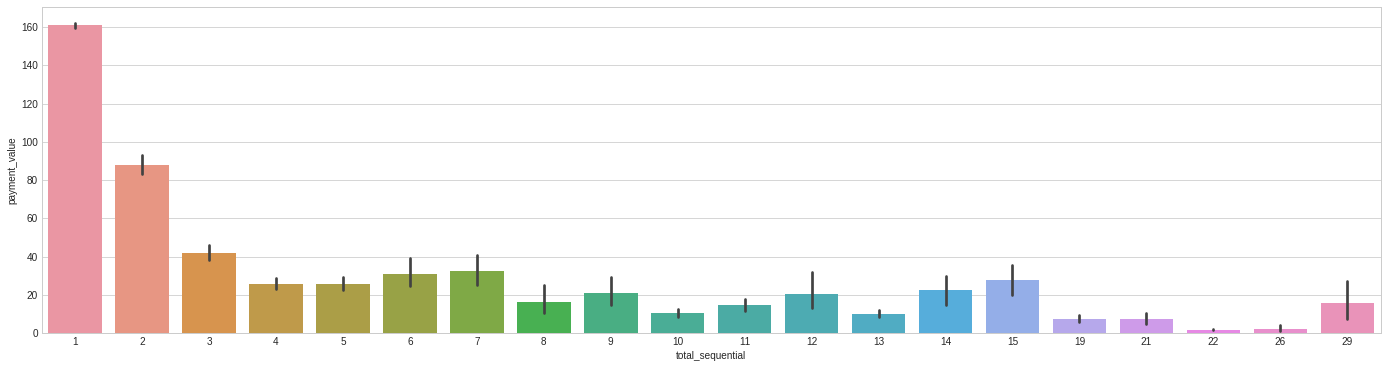

In [0]:
sns.barplot('total_sequential','payment_value',data=dfPayments1)

#### Cleaning
*No cleaning in this dataset

#### Interesting Insights

1. Most Brazilian shop online using credit card.
2. Only around 10,000 people (10% of the data) are loyal to the company
3. Most new customers use credit card as their payment method while loyal customers prefers using voucher. This impacts the purchase value of the customers where new customer tends to spend more (has higher payment value) while loyal customers spends less.

### Orders Dataset
#### Features in Orders Dataset

1. order_id = Generated ID for each order in the dataset (this feature is the primary key for dataset merging)
2. customer_id = Customer's ID for each order
3. order_status = Order status for the corresponding order
4. order_purchase_timestamp = Time when customer places an order
5. order_approved_at = Time when order is approved by the seller and customer
6. order_delivered_carrier_date = Time when order is picked up by the delivery carrier
7. order_delivered_customer_date = Time when order is received by the customer
8. order_estimated_delivery_date = Time estimation of order delivery

In [0]:
dfOrders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [0]:
dfOrders.shape

(99441, 8)

In [0]:
resumetable(dfOrders)

,dataType,null,nullPct,unique,mostValue_1,mostValueCount_1,mostValue_2,mostValueCount_2,mostValue_3,mostValueCount_3,leastValue_1,leastValueCount_1,leastValue_2,leastValueCount_2,leastValue_3,leastValueCount_3
dataFeatures,,,,,,,,,,,,,,,,
order_id,object,0,0.00,99441,dd0710bca2d815cf18148d1d9859fb3b,1.0,e8dcb5c19d58dc860f2c4a1594dff6b3,1.0,b99a2fee4c6c76f8f22757566c90d534,1.0,f2c6ff67de86de120cd2f5ac181e9fd5,1.0,5065c673bd9aed56b2628c56c93d0619,1.0,8e0b25f18db440912bbd8f49eea80abc,1.0
customer_id,object,0,0.00,99441,91a40cc40254f748df9028c2cfce3e69,1.0,c10948fe5d50f2cd031d4db6a153b35a,1.0,1adcfb4ea0149f959526939db0931e6a,1.0,b8f2418875e2a7defe72582767d67bbd,1.0,ec9e3bc81d6b93d5b6602984f860ffce,1.0,a7961e607552d0cebcc486ef283b4c47,1.0
order_status,object,0,0.00,8,delivered,96478.0,shipped,1107.0,canceled,625.0,approved,2.0,created,5.0,processing,301.0
order_purchase_timestamp,object,0,0.00,98875,2018-02-19 15:37:47,3.0,2018-04-11 10:48:14,3.0,2018-03-31 15:08:21,3.0,2017-11-21 18:14:36,1.0,2018-02-26 10:34:45,1.0,2018-06-28 18:11:28,1.0
order_approved_at,object,160,0.16,90733,2018-02-27 04:31:10,9.0,2018-02-06 05:31:52,7.0,2018-01-10 10:32:03,7.0,2017-07-05 02:50:16,1.0,2017-09-12 16:04:53,1.0,2018-05-11 02:57:49,1.0
order_delivered_carrier_date,object,1783,1.79,81018,2018-05-09 15:48:00,47.0,2018-05-10 18:29:00,32.0,2018-05-07 12:31:00,21.0,2018-07-20 15:31:00,1.0,2017-06-02 12:54:46,1.0,2018-07-06 11:13:00,1.0
order_delivered_customer_date,object,2965,2.98,95664,2017-12-02 00:26:45,3.0,2016-10-27 17:32:07,3.0,2018-05-08 23:38:46,3.0,2018-03-28 19:06:30,1.0,2017-11-17 14:14:09,1.0,2017-06-28 09:38:39,1.0
order_estimated_delivery_date,object,0,0.00,459,2017-12-20 00:00:00,522.0,2018-03-12 00:00:00,516.0,2018-03-13 00:00:00,513.0,2017-02-10 00:00:00,1.0,2016-10-04 00:00:00,1.0,2016-10-25 00:00:00,1.0


In [0]:
for col in dfOrders.columns[-5:]:
    dfOrders[col]=pd.to_datetime(dfOrders[col])

In [0]:
resumetable(dfOrders)

,dataType,null,nullPct,unique,mostValue_1,mostValueCount_1,mostValue_2,mostValueCount_2,mostValue_3,mostValueCount_3,leastValue_1,leastValueCount_1,leastValue_2,leastValueCount_2,leastValue_3,leastValueCount_3
dataFeatures,,,,,,,,,,,,,,,,
order_id,object,0,0.00,99441,dd0710bca2d815cf18148d1d9859fb3b,1.0,e8dcb5c19d58dc860f2c4a1594dff6b3,1.0,b99a2fee4c6c76f8f22757566c90d534,1.0,f2c6ff67de86de120cd2f5ac181e9fd5,1.0,5065c673bd9aed56b2628c56c93d0619,1.0,8e0b25f18db440912bbd8f49eea80abc,1.0
customer_id,object,0,0.00,99441,91a40cc40254f748df9028c2cfce3e69,1.0,c10948fe5d50f2cd031d4db6a153b35a,1.0,1adcfb4ea0149f959526939db0931e6a,1.0,b8f2418875e2a7defe72582767d67bbd,1.0,ec9e3bc81d6b93d5b6602984f860ffce,1.0,a7961e607552d0cebcc486ef283b4c47,1.0
order_status,object,0,0.00,8,delivered,96478.0,shipped,1107.0,canceled,625.0,approved,2.0,created,5.0,processing,301.0
order_purchase_timestamp,datetime64[ns],0,0.00,98875,2018-03-31 15:08:21,3.0,2018-08-02 12:06:07,3.0,2017-11-20 10:59:08,3.0,2018-01-04 15:10:45,1.0,2018-05-17 11:29:01,1.0,2017-01-27 12:31:05,1.0
order_approved_at,datetime64[ns],160,0.16,90733,2018-02-27 04:31:10,9.0,2017-12-05 10:30:42,7.0,2018-01-10 10:32:03,7.0,2018-04-09 11:10:40,1.0,2017-07-20 02:10:59,1.0,2017-08-21 07:30:12,1.0
order_delivered_carrier_date,datetime64[ns],1783,1.79,81018,2018-05-09 15:48:00,47.0,2018-05-10 18:29:00,32.0,2018-05-07 12:31:00,21.0,2017-11-24 20:36:56,1.0,2017-08-17 16:25:12,1.0,2017-05-29 09:37:31,1.0
order_delivered_customer_date,datetime64[ns],2965,2.98,95664,2018-05-14 20:02:44,3.0,2018-07-24 21:36:42,3.0,2017-12-02 00:26:45,3.0,2018-04-24 18:58:46,1.0,2017-01-30 15:06:11,1.0,2018-03-27 15:36:38,1.0
order_estimated_delivery_date,datetime64[ns],0,0.00,459,2017-12-20 00:00:00,522.0,2018-03-12 00:00:00,516.0,2018-03-13 00:00:00,513.0,2018-11-12 00:00:00,1.0,2016-11-07 00:00:00,1.0,2018-07-06 00:00:00,1.0


In [0]:
dfOrders.describe()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
count,99441,99441,99441,99441,99281,97658,96476,99441
unique,99441,99441,8,98875,90733,81018,95664,459
top,dd0710bca2d815cf18148d1d9859fb3b,91a40cc40254f748df9028c2cfce3e69,delivered,2018-03-31 15:08:21,2018-02-27 04:31:10,2018-05-09 15:48:00,2018-05-14 20:02:44,2017-12-20 00:00:00
freq,1,1,96478,3,9,47,3,522
first,NaN,NaN,NaN,2016-09-04 21:15:19,2016-09-15 12:16:38,2016-10-08 10:34:01,2016-10-11 13:46:32,2016-09-30 00:00:00
last,NaN,NaN,NaN,2018-10-17 17:30:18,2018-09-03 17:40:06,2018-09-11 19:48:28,2018-10-17 13:22:46,2018-11-12 00:00:00


In [0]:
dfOrders[dfOrders['order_approved_at'].isna()].isna().sum()

order_id                           0
customer_id                        0
order_status                       0
order_purchase_timestamp           0
order_approved_at                160
order_delivered_carrier_date     146
order_delivered_customer_date    146
order_estimated_delivery_date      0
dtype: int64

In [0]:
dfOrders[dfOrders['order_delivered_carrier_date'].isna()].isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 146
order_delivered_carrier_date     1783
order_delivered_customer_date    1782
order_estimated_delivery_date       0
dtype: int64

In [0]:
dfOrders[dfOrders['order_delivered_customer_date'].isna()].isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 146
order_delivered_carrier_date     1782
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [0]:
dfOrders[dfOrders['order_approved_at'].isna()]['order_status'].value_counts()

canceled     141
delivered     14
created        5
Name: order_status, dtype: int64

In [0]:
dfOrders[dfOrders['order_delivered_carrier_date'].isna()]['order_status'].value_counts()

unavailable    609
canceled       550
invoiced       314
processing     301
created          5
delivered        2
approved         2
Name: order_status, dtype: int64

In [0]:
dfOrders[dfOrders['order_delivered_customer_date'].isna()]['order_status'].value_counts()

shipped        1107
canceled        619
unavailable     609
invoiced        314
processing      301
delivered         8
created           5
approved          2
Name: order_status, dtype: int64

In [0]:
dfOrders['order_status'].value_counts()

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

(array([736238., 736330., 736420., 736511., 736603., 736695., 736785.,
        736876., 736968.]), <a list of 9 Text xticklabel objects>)

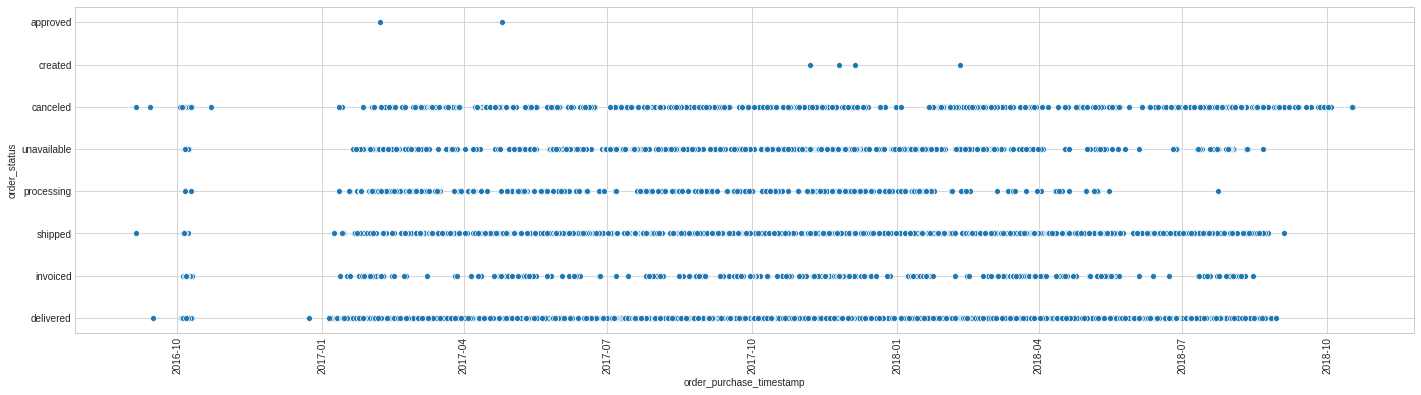

In [0]:
plt.figure(figsize=(24,6))
sns.scatterplot('order_purchase_timestamp','order_status',data=dfOrders)
plt.xticks(rotation=90)

In [0]:
dfOrder_null_status=pd.DataFrame(dfOrders['order_status'].value_counts()).rename(columns={'order_status':'actual_order_status'})
for col in dfOrders.columns[-5:]:
    dfOrder_null_status[col]=dfOrders[dfOrders[col].isna()]['order_status'].value_counts()#.reindex(list(dfOrders['order_status'].value_counts().index))
    dfOrder_null_status[f'{col}_perc']=round(dfOrder_null_status.iloc[:,-1]/dfOrder_null_status.iloc[:,0]*100,3)
dfOrder_null_status.T

,delivered,shipped,canceled,unavailable,invoiced,processing,created,approved
actual_order_status,96478.000,1107.0,625.00,609.0,314.0,301.0,5.0,2.0
order_purchase_timestamp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
order_purchase_timestamp_perc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
order_approved_at,14.000,NaN,141.00,NaN,NaN,NaN,5.0,NaN
order_approved_at_perc,0.015,NaN,22.56,NaN,NaN,NaN,100.0,NaN
order_delivered_carrier_date,2.000,NaN,550.00,609.0,314.0,301.0,5.0,2.0
order_delivered_carrier_date_perc,0.002,NaN,88.00,100.0,100.0,100.0,100.0,100.0
order_delivered_customer_date,8.000,1107.0,619.00,609.0,314.0,301.0,5.0,2.0
order_delivered_customer_date_perc,0.008,100.0,99.04,100.0,100.0,100.0,100.0,100.0
order_estimated_delivery_date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
dfOrders1=dfOrders.copy()
dfOrders1['delivery_estimation_days']=(dfOrders['order_estimated_delivery_date']-dfOrders['order_purchase_timestamp']).dt.days
dfOrders1['delivery_diff']=(dfOrders['order_delivered_customer_date']-dfOrders['order_estimated_delivery_date']).dt.days
dfOrders1.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivery_estimation_days,delivery_diff
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,15,-8.0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,19,-6.0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,26,-18.0
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,26,-13.0
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,12,-10.0


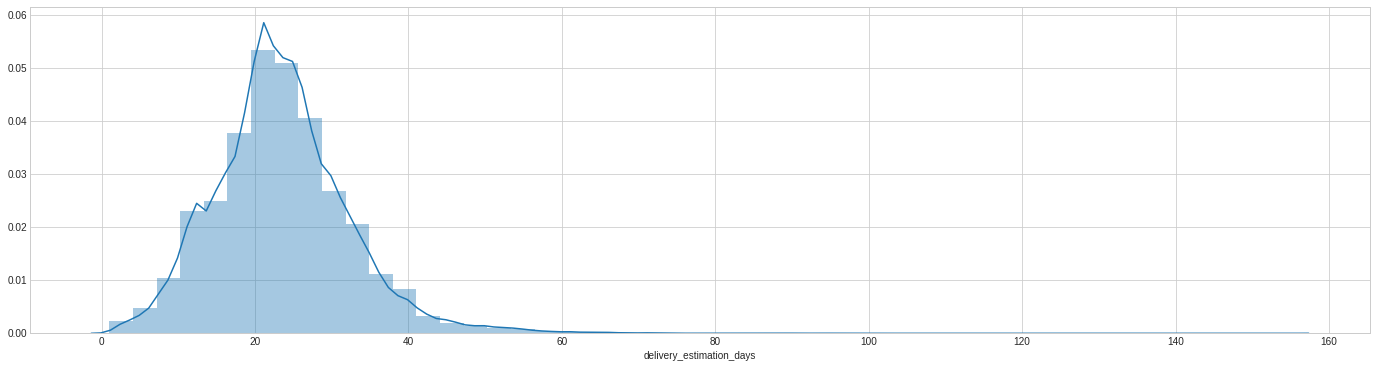

In [0]:
sns.distplot(dfOrders1['delivery_estimation_days'])

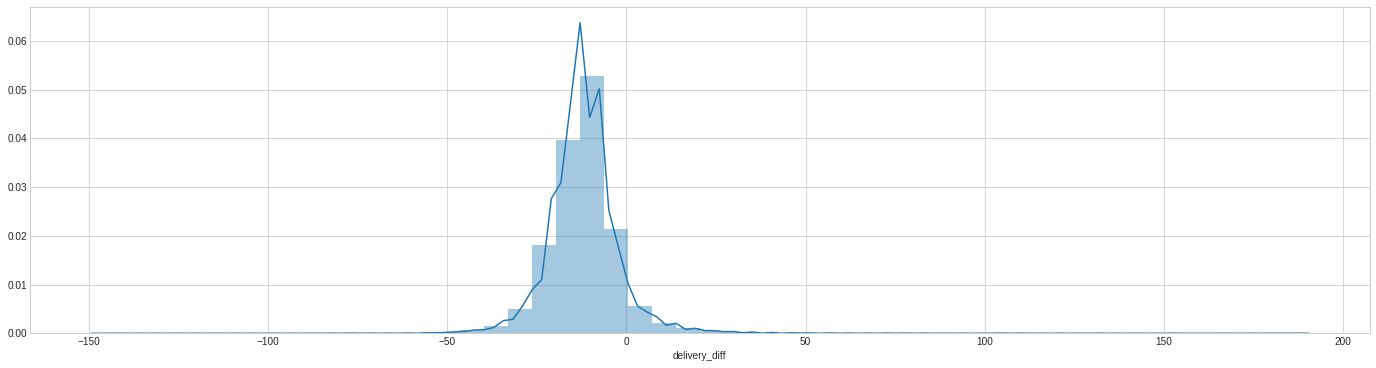

In [0]:
sns.distplot(dfOrders1['delivery_diff'].dropna())

In [0]:
dfOrders1.groupby('order_status').agg(['sum','mean','min','max','count'])

delivery_estimation_days                             \
                                  sum       mean min  max  count   
order_status                                                       
approved                           48  24.000000  22   26      2   
canceled                        13923  22.276800   1  144    625   
created                           134  26.800000  16   36      5   
delivered                     2254957  23.372759   2  155  96478   
invoiced                         7863  25.041401   2   64    314   
processing                       8892  29.541528  10  144    301   
shipped                         27457  24.803071   2  142   1107   
unavailable                     14039  23.052545   2   66    609   

             delivery_diff                                  
                       sum       mean    min    max  count  
order_status                                                
approved               0.0        NaN    NaN    NaN      0  
canceled            -167.0 -27.833333  -46.0   12.0      6  
created                0.0        NaN    NaN    NaN      0  
delivered       -1145667.0 -11.875889 -147.0  188.0  96470  
invoiced               0.0        NaN    NaN    NaN      0  
processing             0.0        NaN    NaN    NaN      0  
shipped                0.0        NaN    NaN    NaN      0  
unavailable            0.0        NaN    NaN    NaN      0

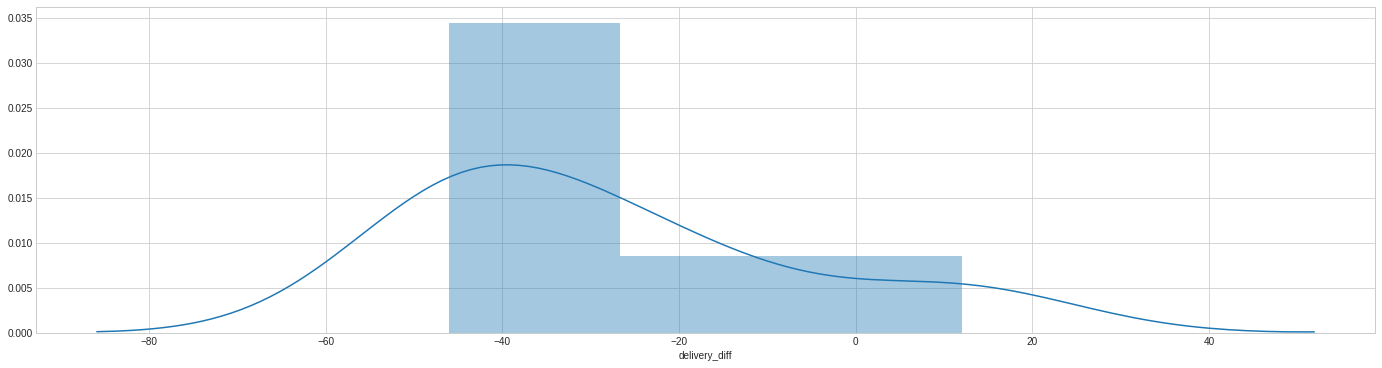

In [0]:
sns.distplot(dfOrders1[dfOrders['order_status']=='canceled']['delivery_diff'].dropna())

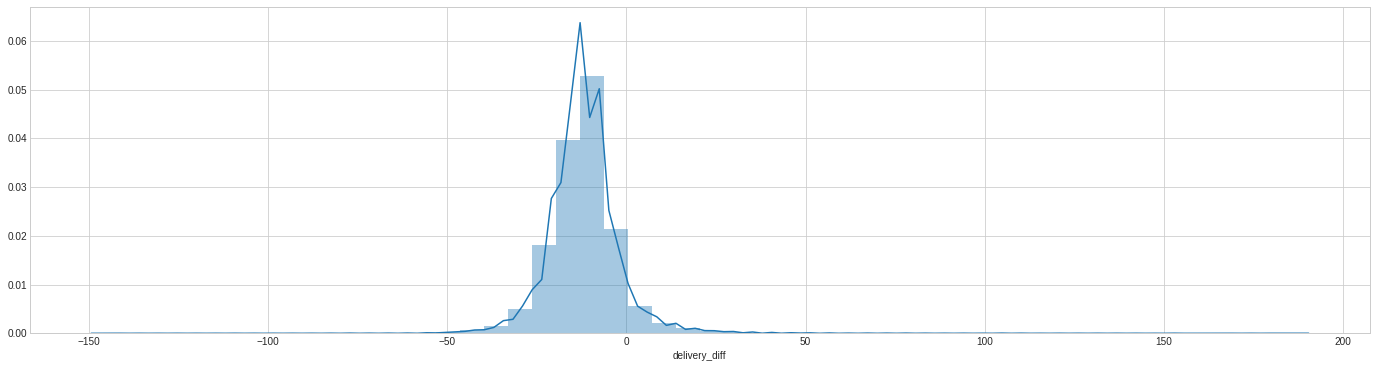

In [0]:
sns.distplot(dfOrders1[dfOrders['order_status']=='delivered']['delivery_diff'].dropna())

(735962.0, 737060.0)

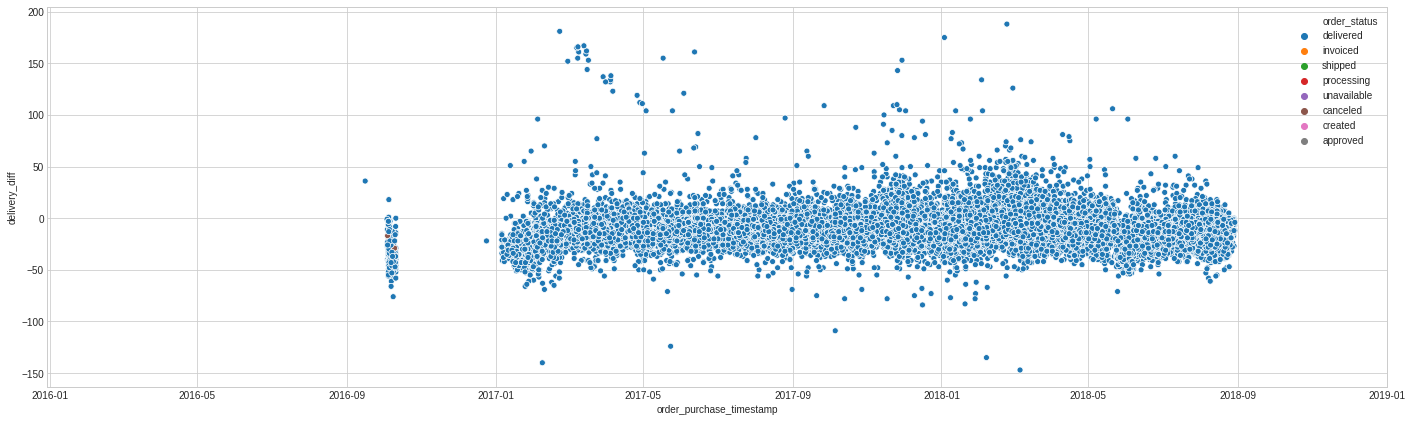

In [0]:
plt.figure(figsize=(24,7))
sns.scatterplot('order_purchase_timestamp','delivery_diff','order_status',data=dfOrders1)
plt.xlim(pd.Timestamp(2015,12,30),pd.Timestamp(2019,1,1))

(735962.0, 737060.0)

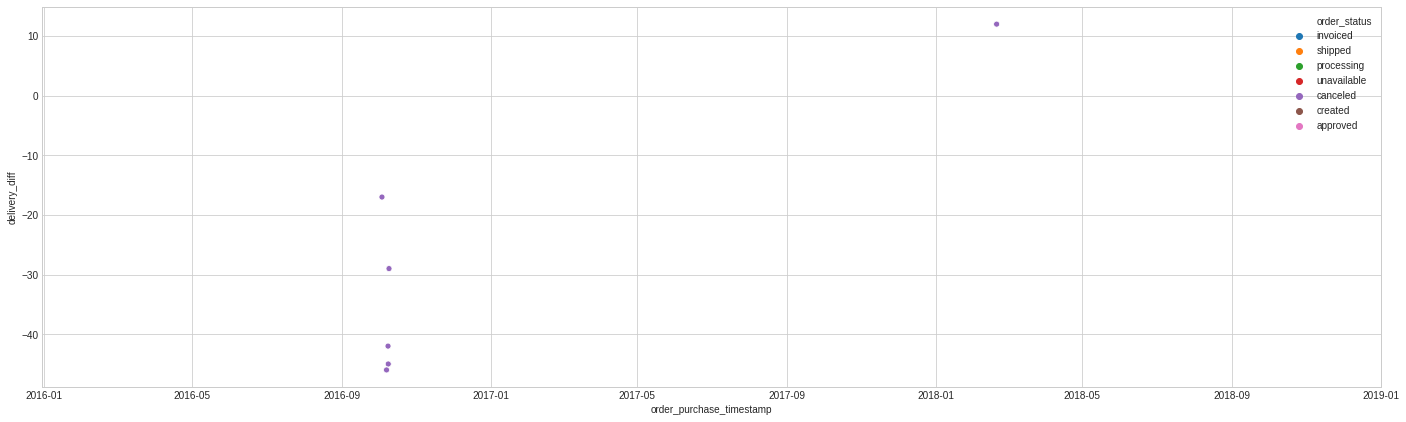

In [0]:
plt.figure(figsize=(24,7))
sns.scatterplot('order_purchase_timestamp','delivery_diff','order_status',data=dfOrders1[dfOrders1['order_status']!='delivered'])
plt.xlim(pd.Timestamp(2015,12,30),pd.Timestamp(2019,1,1))

In [0]:
dfOrders1[(dfOrders['order_status']=='canceled')&(dfOrders1['delivery_diff'].notnull())]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivery_estimation_days,delivery_diff
2921,1950d777989f6a877539f53795b4c3c3,1bccb206de9f0f25adc6871a1bcf77b2,canceled,2018-02-19 19:48:52,2018-02-19 20:56:05,2018-02-20 19:57:13,2018-03-21 22:03:51,2018-03-09,17,12.0
8791,dabf2b0e35b423f94618bf965fcb7514,5cdec0bb8cbdf53ffc8fdc212cd247c6,canceled,2016-10-09 00:56:52,2016-10-09 13:36:58,2016-10-13 13:36:59,2016-10-16 14:36:59,2016-11-30,51,-45.0
58266,770d331c84e5b214bd9dc70a10b829d0,6c57e6119369185e575b36712766b0ef,canceled,2016-10-07 14:52:30,2016-10-07 15:07:10,2016-10-11 15:07:11,2016-10-14 15:07:11,2016-11-29,52,-46.0
59332,8beb59392e21af5eb9547ae1a9938d06,bf609b5741f71697f65ce3852c5d2623,canceled,2016-10-08 20:17:50,2016-10-09 14:34:30,2016-10-14 22:45:26,2016-10-19 18:47:43,2016-11-30,52,-42.0
92636,65d1e226dfaeb8cdc42f665422522d14,70fc57eeae292675927697fe03ad3ff5,canceled,2016-10-03 21:01:41,2016-10-04 10:18:57,2016-10-25 12:14:28,2016-11-08 10:58:34,2016-11-25,52,-17.0
94399,2c45c33d2f9cb8ff8b1c86cc28c11c30,de4caa97afa80c8eeac2ff4c8da5b72e,canceled,2016-10-09 15:39:56,2016-10-10 10:40:49,2016-10-14 10:40:50,2016-11-09 14:53:50,2016-12-08,59,-29.0


#### Cleaning
1. Converted order_purchase_timestamp, order_approved_status, order_delivered_carrier_date, order_delivered_customer_date, and order_estimated_delivery_date features type from object type to datetime type

#### Interesting Insights

1. Most of the orders are delivered before their estimated delivery date.

2. Most of the canceled order occurs on October of 2016, but they're somehow delivered to the customers 

### Reviews Dataset
#### Features in Reviews Dataset

1. review_id = ID generated for each review in the dataset
2. order_id = order_id corresponding to the review
3. review_score = Review score given by the customer
4. review_comment_title = Title of review given by the customer for the corresponding order_id
5. review_comment_message = Message of the review given by the customer for the corresponding order_id
6. review_creation_date = Time when the review form is generated
7. review_answer_timestamp = Time when the filled review form is submitted by the customer

In [0]:
dfReviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [0]:
dfReviews.shape

(100000, 7)

In [0]:
resumetable(dfReviews)

,dataType,null,nullPct,unique,mostValue_1,mostValueCount_1,mostValue_2,mostValueCount_2,mostValue_3,mostValueCount_3,leastValue_1,leastValueCount_1,leastValue_2,leastValueCount_2,leastValue_3,leastValueCount_3
dataFeatures,,,,,,,,,,,,,,,,
review_id,object,0,0.00,99173,ddc52555ca27b0fe67d5255147682d2d,3.0,4548534449b1f572e357211b90724f1b,3.0,f4bb9d6dd4fb6dcc2298f0e7b17b8e1e,3.0,065d03dd5bc03e680bd200d1e83524ea,1.0,547b9cec12492ca8b94c346f762e3c9d,1.0,e84f865e8f870bc3ea5510c0f3fd1a46,1.0
order_id,object,0,0.00,99441,8e17072ec97ce29f0e1f111e598b0c85,3.0,df56136b8031ecd28e200bb18e6ddb2e,3.0,c88b1d1b157a9999ce368f218a407141,3.0,e27f8086e3d62693b719af33a78cffdc,1.0,107140930f283788e31acf6904a4c50d,1.0,0e1ddbe485dfa358d24e22e5394d0484,1.0
review_score,int64,0,0.00,5,5,57420.0,4,19200.0,1,11858.0,2,3235.0,3,8287.0,1,11858.0
review_comment_title,object,88285,88.28,4600,Recomendo,426.0,recomendo,346.0,Bom,294.0,recomendo com segurança,1.0,Excelente o produto amei,1.0,Poderia ser melhor embala,1.0
review_comment_message,object,58247,58.25,36921,Muito bom,230.0,Bom,189.0,muito bom,122.0,O vendedor não tinha o produto pedido cancelado,1.0,MUITO RÁPIDA A ENTREGA E ÓTIMO PRODUTO,1.0,"Excelente produto, igual ao descrito! Entrega ...",1.0
review_creation_date,object,0,0.00,637,2017-12-19 00:00:00,466.0,2018-08-28 00:00:00,453.0,2017-12-20 00:00:00,445.0,2017-03-13 00:00:00,1.0,2018-02-13 00:00:00,1.0,2018-07-23 00:00:00,1.0
review_answer_timestamp,object,0,0.00,99010,2017-06-15 23:21:05,4.0,2018-08-06 00:09:52,3.0,2017-06-25 14:04:22,3.0,2017-05-08 12:48:15,1.0,2017-10-20 16:17:26,1.0,2018-05-24 19:05:25,1.0


In [0]:
for col in dfReviews.columns[-2:]:
    dfReviews[col]=pd.to_datetime(dfReviews[col])

In [0]:
resumetable(dfReviews).T

dataFeatures,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
dataType,object,object,int64,object,object,datetime64[ns],datetime64[ns]
null,0,0,0,88285,58247,0,0
nullPct,0,0,0,88.28,58.25,0,0
unique,99173,99441,5,4600,36921,637,99010
mostValue_1,ddc52555ca27b0fe67d5255147682d2d,8e17072ec97ce29f0e1f111e598b0c85,5,Recomendo,Muito bom,2017-12-19 00:00:00,2017-06-15 23:21:05
mostValueCount_1,3,3,57420,426,230,466,4
mostValue_2,4548534449b1f572e357211b90724f1b,df56136b8031ecd28e200bb18e6ddb2e,4,recomendo,Bom,2018-08-28 00:00:00,2018-07-31 23:11:57
mostValueCount_2,3,3,19200,346,189,453,3
mostValue_3,f4bb9d6dd4fb6dcc2298f0e7b17b8e1e,c88b1d1b157a9999ce368f218a407141,1,Bom,muito bom,2017-12-20 00:00:00,2018-08-06 00:09:52
mostValueCount_3,3,3,11858,294,122,445,3


In [0]:
dfReviews.describe()

,review_score
count,100000.000000
mean,4.070890
std,1.359663
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


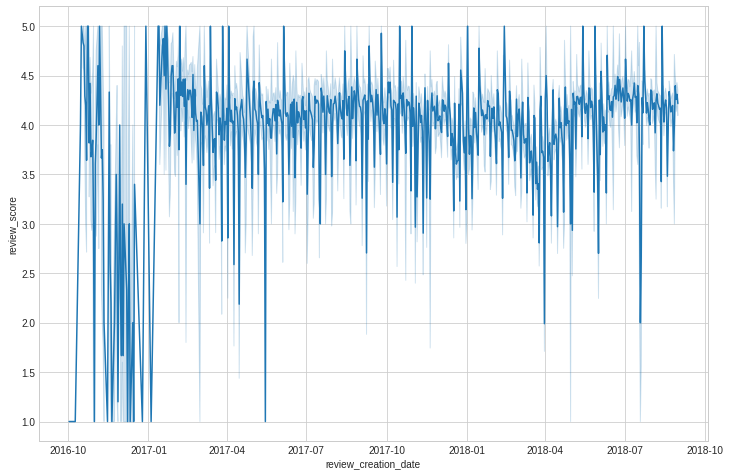

In [0]:
plt.figure(figsize=(12,8))
sns.lineplot('review_creation_date','review_score',data=dfReviews)

In [0]:
dfReviews1=dfReviews.copy()
for col in dfReviews.columns[-2:]:
    dfReviews1[f'{col}_year']=dfReviews[col].apply(lambda x: x.year)
dfReviews1['review_diff']=(dfReviews['review_answer_timestamp']-dfReviews['review_creation_date']).dt.days
dfReviews1.head().T

,0,1,2,3,4
review_id,7bc2406110b926393aa56f80a40eba40,80e641a11e56f04c1ad469d5645fdfde,228ce5500dc1d8e020d8d1322874b6f0,e64fb393e7b32834bb789ff8bb30750e,f7c4243c7fe1938f181bec41a392bdeb
order_id,73fc7af87114b39712e6da79b0a377eb,a548910a1c6147796b98fdf73dbeba33,f9e4b658b201a9f2ecdecbb34bed034b,658677c97b385a9be170737859d3511b,8e6bfb81e283fa7e4f11123a3fb894f1
review_score,4,5,5,5,5
review_comment_title,NaN,NaN,NaN,NaN,NaN
review_comment_message,NaN,NaN,NaN,Recebi bem antes do prazo estipulado.,Parabéns lojas lannister adorei comprar pela I...
review_creation_date,2018-01-18 00:00:00,2018-03-10 00:00:00,2018-02-17 00:00:00,2017-04-21 00:00:00,2018-03-01 00:00:00
review_answer_timestamp,2018-01-18 21:46:59,2018-03-11 03:05:13,2018-02-18 14:36:24,2017-04-21 22:02:06,2018-03-02 10:26:53
review_creation_date_year,2018,2018,2018,2017,2018
review_answer_timestamp_year,2018,2018,2018,2017,2018
review_diff,0,1,1,0,1


In [0]:
resumetable(dfReviews1)

,dataType,null,nullPct,unique,mostValue_1,mostValueCount_1,mostValue_2,mostValueCount_2,mostValue_3,mostValueCount_3,leastValue_1,leastValueCount_1,leastValue_2,leastValueCount_2,leastValue_3,leastValueCount_3
dataFeatures,,,,,,,,,,,,,,,,
review_id,object,0,0.00,99173,ddc52555ca27b0fe67d5255147682d2d,3.0,4548534449b1f572e357211b90724f1b,3.0,f4bb9d6dd4fb6dcc2298f0e7b17b8e1e,3.0,065d03dd5bc03e680bd200d1e83524ea,1.0,547b9cec12492ca8b94c346f762e3c9d,1.0,e84f865e8f870bc3ea5510c0f3fd1a46,1.0
order_id,object,0,0.00,99441,8e17072ec97ce29f0e1f111e598b0c85,3.0,df56136b8031ecd28e200bb18e6ddb2e,3.0,c88b1d1b157a9999ce368f218a407141,3.0,e27f8086e3d62693b719af33a78cffdc,1.0,107140930f283788e31acf6904a4c50d,1.0,0e1ddbe485dfa358d24e22e5394d0484,1.0
review_score,int64,0,0.00,5,5,57420.0,4,19200.0,1,11858.0,2,3235.0,3,8287.0,1,11858.0
review_comment_title,object,88285,88.28,4600,Recomendo,426.0,recomendo,346.0,Bom,294.0,recomendo com segurança,1.0,Excelente o produto amei,1.0,Poderia ser melhor embala,1.0
review_comment_message,object,58247,58.25,36921,Muito bom,230.0,Bom,189.0,muito bom,122.0,O vendedor não tinha o produto pedido cancelado,1.0,MUITO RÁPIDA A ENTREGA E ÓTIMO PRODUTO,1.0,"Excelente produto, igual ao descrito! Entrega ...",1.0
review_creation_date,datetime64[ns],0,0.00,637,2017-12-19 00:00:00,466.0,2018-08-28 00:00:00,453.0,2017-12-20 00:00:00,445.0,2016-10-06 00:00:00,1.0,2018-07-23 00:00:00,1.0,2017-02-06 00:00:00,1.0
review_answer_timestamp,datetime64[ns],0,0.00,99010,2017-06-15 23:21:05,4.0,2018-07-31 23:11:57,3.0,2018-08-06 00:09:52,3.0,2018-03-19 17:56:53,1.0,2017-07-11 23:19:12,1.0,2017-07-17 12:11:06,1.0
review_creation_date_year,int64,0,0.00,3,2018,56584.0,2017,43085.0,2016,331.0,2016,331.0,2017,43085.0,2018,56584.0
review_answer_timestamp_year,int64,0,0.00,3,2018,57269.0,2017,42414.0,2016,317.0,2016,317.0,2017,42414.0,2018,57269.0


In [0]:
dfReviews1.groupby('review_creation_date_year').describe().T

review_creation_date_year                  2016          2017          2018
review_score                 count   331.000000  43085.000000  56584.000000
                             mean      3.510574      4.093838      4.056694
                             std       1.713328      1.333784      1.375879
                             min       1.000000      1.000000      1.000000
                             25%       1.000000      4.000000      4.000000
                             50%       4.000000      5.000000      5.000000
                             75%       5.000000      5.000000      5.000000
                             max       5.000000      5.000000      5.000000
review_answer_timestamp_year count   331.000000  43085.000000  56584.000000
                             mean   2016.042296   2017.015899   2018.000000
                             std       0.201569      0.125086      0.000000
                             min    2016.000000   2017.000000   2018.000000
                             25%    2016.000000   2017.000000   2018.000000
                             50%    2016.000000   2017.000000   2018.000000
                             75%    2016.000000   2017.000000   2018.000000
                             max    2017.000000   2018.000000   2018.000000
review_diff                  count   331.000000  43085.000000  56584.000000
                             mean      8.157100      2.863967      2.332744
                             std      27.652598     12.863222      6.417012
                             min       0.000000      0.000000      0.000000
                             25%       1.000000      1.000000      0.000000
                             50%       2.000000      1.000000      1.000000
                             75%       3.000000      3.000000      3.000000
                             max     250.000000    518.000000    281.000000

In [0]:
dfReviews1.groupby('review_answer_timestamp_year').describe().T

review_answer_timestamp_year            2016          2017          2018
review_score              count   317.000000  42414.000000  57269.000000
                          mean      3.495268      4.096761      4.054916
                          std       1.718517      1.330802      1.377525
                          min       1.000000      1.000000      1.000000
                          25%       1.000000      4.000000      4.000000
                          50%       4.000000      5.000000      5.000000
                          75%       5.000000      5.000000      5.000000
                          max       5.000000      5.000000      5.000000
review_creation_date_year count   317.000000  42414.000000  57269.000000
                          mean   2016.000000   2016.999670   2017.988039
                          std       0.000000      0.018165      0.108712
                          min    2016.000000   2016.000000   2017.000000
                          25%    2016.000000   2017.000000   2018.000000
                          50%    2016.000000   2017.000000   2018.000000
                          75%    2016.000000   2017.000000   2018.000000
                          max    2016.000000   2017.000000   2018.000000
review_diff               count   317.000000  42414.000000  57269.000000
                          mean      3.296530      2.391357      2.717317
                          std       6.739297      7.578452     11.271201
                          min       0.000000      0.000000      0.000000
                          25%       1.000000      1.000000      0.000000
                          50%       2.000000      1.000000      1.000000
                          75%       3.000000      3.000000      3.000000
                          max      69.000000    268.000000    518.000000

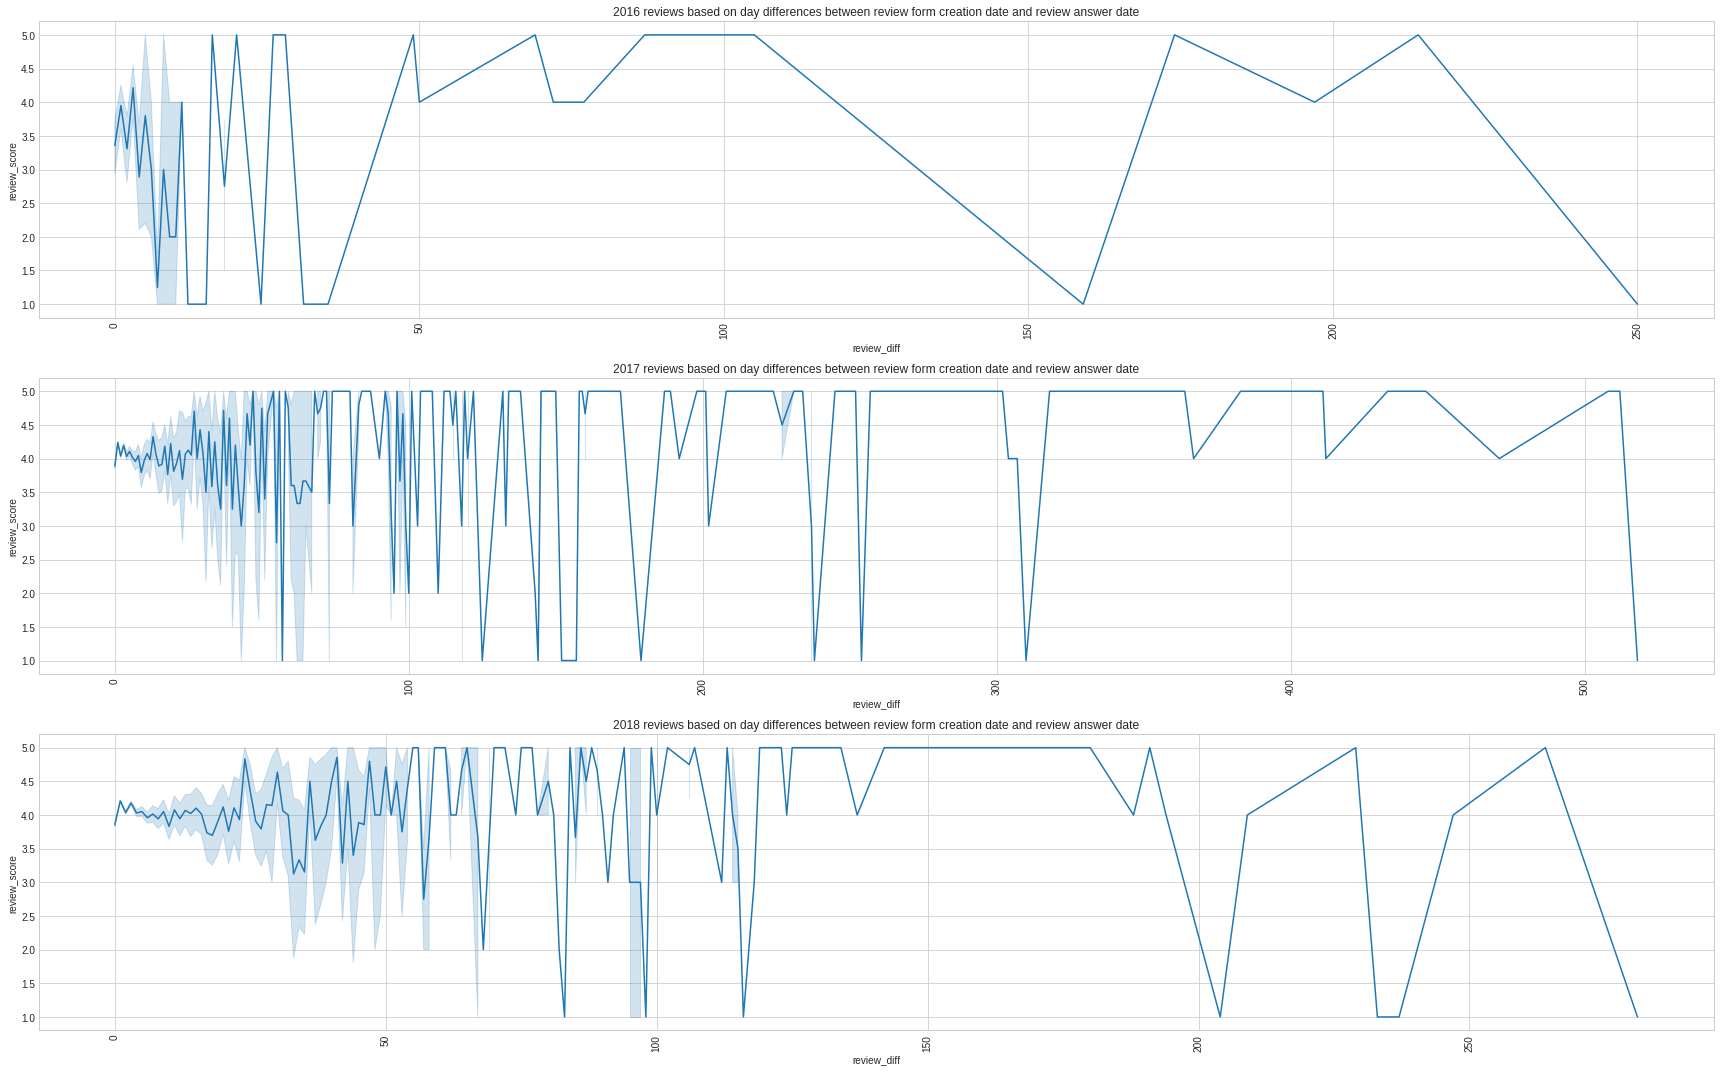

In [0]:
fig,axes=plt.subplots(3,1,figsize=(24,5*3),sharey=True)
for yr,ax in zip([2016,2017,2018],axes):
    data=dfReviews1[dfReviews1[f'review_creation_date_year']==yr]
    sns.lineplot('review_diff','review_score',data=data,ax=ax)
    ax.tick_params('x',labelrotation=90)
    ax.set_title(f'{yr} reviews based on day differences between review form creation date and review answer date')
plt.tight_layout()

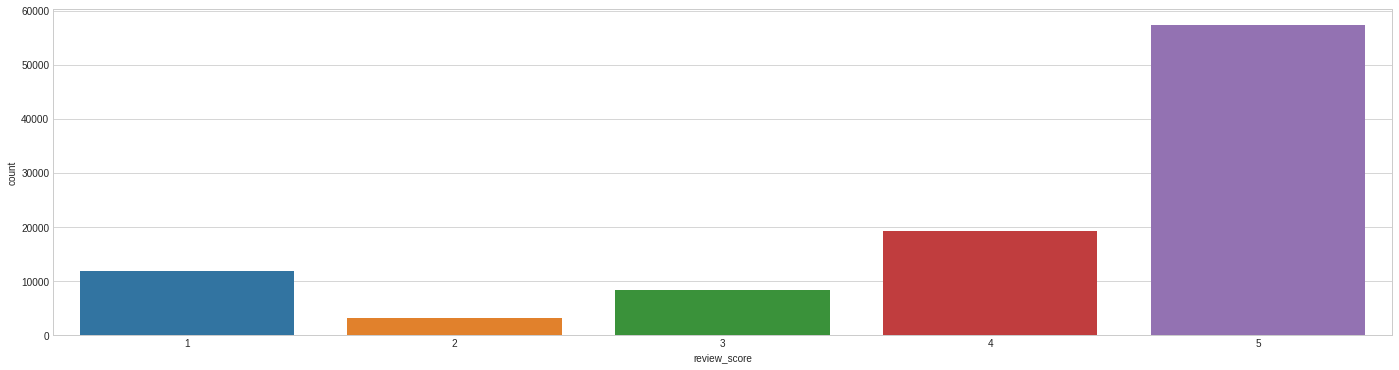

In [0]:
sns.countplot(dfReviews['review_score'])

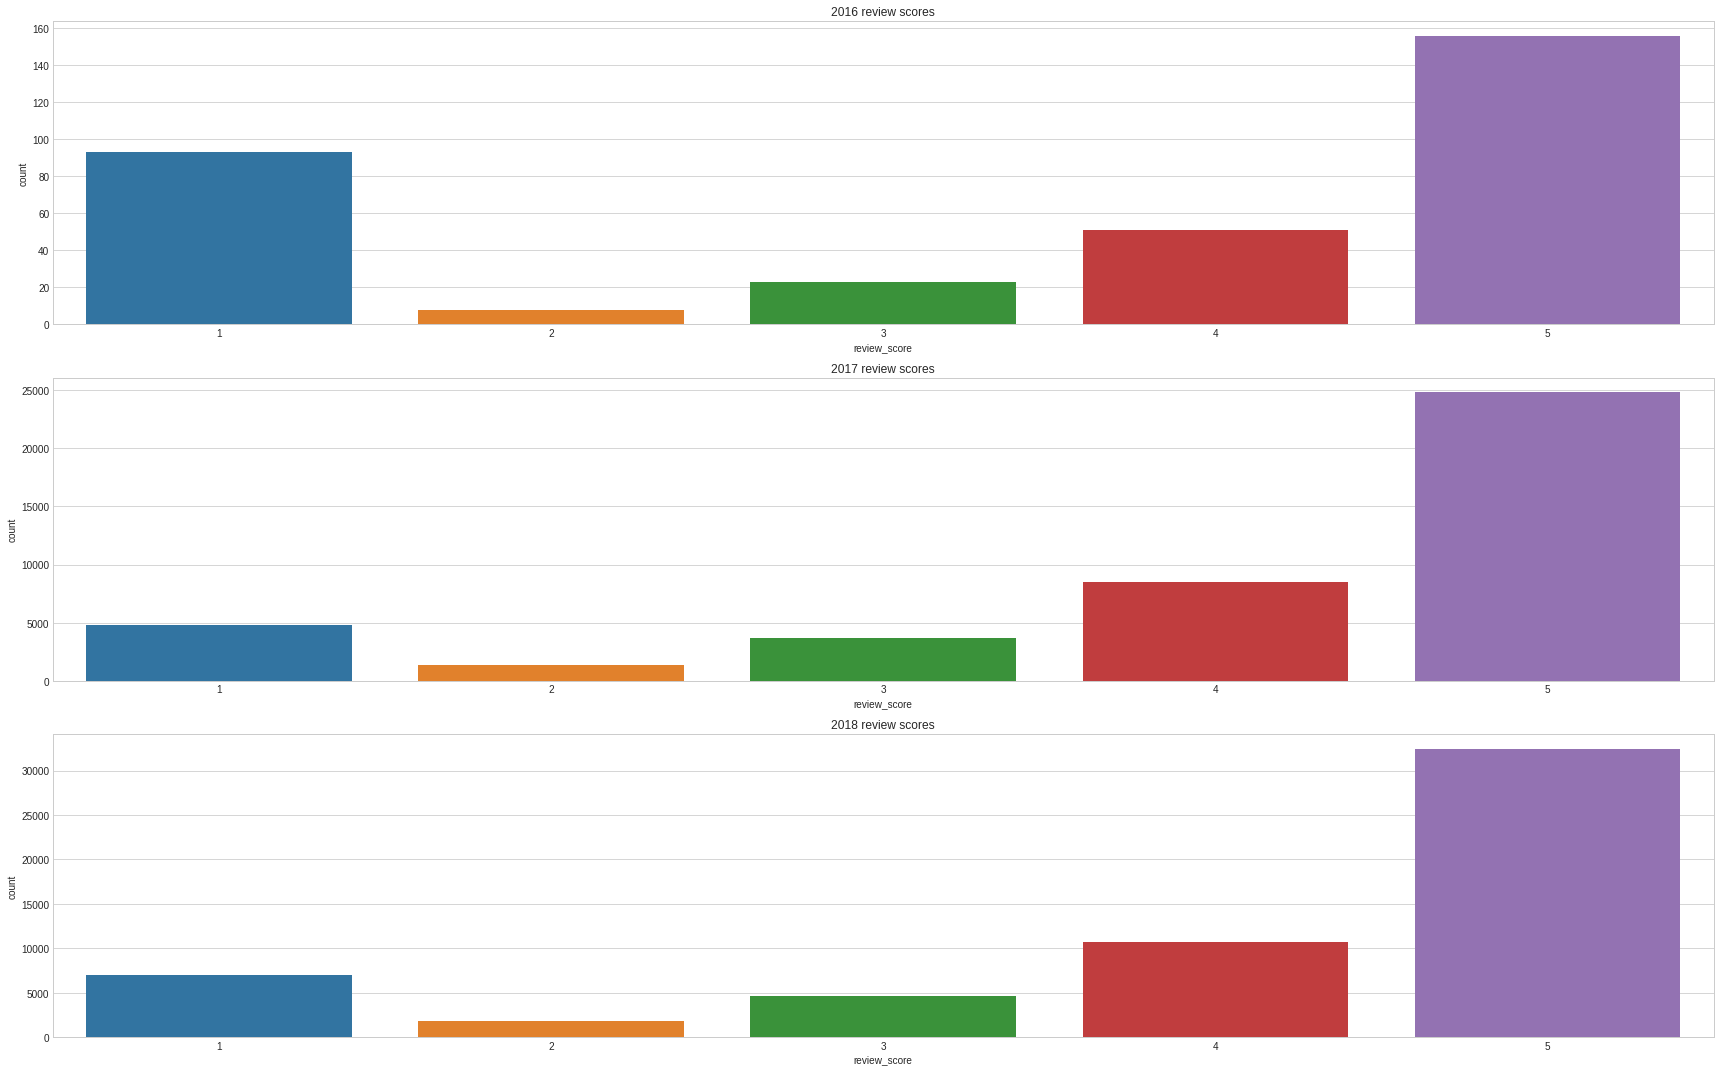

In [0]:
fig,axes=plt.subplots(3,1,figsize=(24,5*3),)
for yr,ax in zip([2016,2017,2018],axes):
#     print(axe)
#     for col,ax in zip(dfReviews.columns[-2:],axe):
    data=dfReviews[dfReviews1[f'review_creation_date_year']==yr]['review_score']
    sns.countplot(data,ax=ax)
#     ax.tick_params('x',labelrotation=90)
    ax.set_title(f'{yr} review scores')
plt.tight_layout()

In [0]:
dfReviews['review_score'].describe()

count    100000.000000
mean          4.070890
std           1.359663
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: review_score, dtype: float64

In [0]:
agg=dfReviews1.groupby('review_score')['review_diff'].agg(['mean','std','median','min','max'])
agg['mode']=agg.index.map({i:dfReviews1[dfReviews1['review_score']==i]['review_diff'].mode()[0] for i in range(1,6)})
agg

,mean,std,median,min,max,mode
review_score,,,,,,
1,2.501771,10.401335,1,0,518,0
2,2.426893,6.429184,1,0,143,0
3,2.416073,6.087457,1,0,202,1
4,2.547865,8.880687,1,0,471,1
5,2.640752,10.631545,1,0,512,1


In [0]:
dfReviews1.groupby('review_creation_date_year').describe().T

review_creation_date_year                  2016          2017          2018
review_score                 count   331.000000  43085.000000  56584.000000
                             mean      3.510574      4.093838      4.056694
                             std       1.713328      1.333784      1.375879
                             min       1.000000      1.000000      1.000000
                             25%       1.000000      4.000000      4.000000
                             50%       4.000000      5.000000      5.000000
                             75%       5.000000      5.000000      5.000000
                             max       5.000000      5.000000      5.000000
review_answer_timestamp_year count   331.000000  43085.000000  56584.000000
                             mean   2016.042296   2017.015899   2018.000000
                             std       0.201569      0.125086      0.000000
                             min    2016.000000   2017.000000   2018.000000
                             25%    2016.000000   2017.000000   2018.000000
                             50%    2016.000000   2017.000000   2018.000000
                             75%    2016.000000   2017.000000   2018.000000
                             max    2017.000000   2018.000000   2018.000000
review_diff                  count   331.000000  43085.000000  56584.000000
                             mean      8.157100      2.863967      2.332744
                             std      27.652598     12.863222      6.417012
                             min       0.000000      0.000000      0.000000
                             25%       1.000000      1.000000      0.000000
                             50%       2.000000      1.000000      1.000000
                             75%       3.000000      3.000000      3.000000
                             max     250.000000    518.000000    281.000000

In [0]:
dfReviews1.groupby('review_answer_timestamp_year').describe().T

review_answer_timestamp_year            2016          2017          2018
review_score              count   317.000000  42414.000000  57269.000000
                          mean      3.495268      4.096761      4.054916
                          std       1.718517      1.330802      1.377525
                          min       1.000000      1.000000      1.000000
                          25%       1.000000      4.000000      4.000000
                          50%       4.000000      5.000000      5.000000
                          75%       5.000000      5.000000      5.000000
                          max       5.000000      5.000000      5.000000
review_creation_date_year count   317.000000  42414.000000  57269.000000
                          mean   2016.000000   2016.999670   2017.988039
                          std       0.000000      0.018165      0.108712
                          min    2016.000000   2016.000000   2017.000000
                          25%    2016.000000   2017.000000   2018.000000
                          50%    2016.000000   2017.000000   2018.000000
                          75%    2016.000000   2017.000000   2018.000000
                          max    2016.000000   2017.000000   2018.000000
review_diff               count   317.000000  42414.000000  57269.000000
                          mean      3.296530      2.391357      2.717317
                          std       6.739297      7.578452     11.271201
                          min       0.000000      0.000000      0.000000
                          25%       1.000000      1.000000      0.000000
                          50%       2.000000      1.000000      1.000000
                          75%       3.000000      3.000000      3.000000
                          max      69.000000    268.000000    518.000000

In [0]:
dfReviews['review_creation_date'].sort_values().head()

71485   2016-10-02
37828   2016-10-06
5538    2016-10-09
60918   2016-10-15
41350   2016-10-15
Name: review_creation_date, dtype: datetime64[ns]

In [0]:
dfReviews['review_creation_date'].value_counts().resample('M').sum()

2016-10-31     181
2016-11-30     102
2016-12-31      48
2017-01-31     239
2017-02-28    1424
2017-03-31    2505
2017-04-30    2067
2017-05-31    3736
2017-06-30    3477
2017-07-31    3532
2017-08-31    4533
2017-09-30    4244
2017-10-31    4450
2017-11-30    4824
2017-12-31    8054
2018-01-31    6240
2018-02-28    6168
2018-03-31    7862
2018-04-30    7350
2018-05-31    7511
2018-06-30    6744
2018-07-31    5671
2018-08-31    9038
Freq: M, Name: review_creation_date, dtype: int64

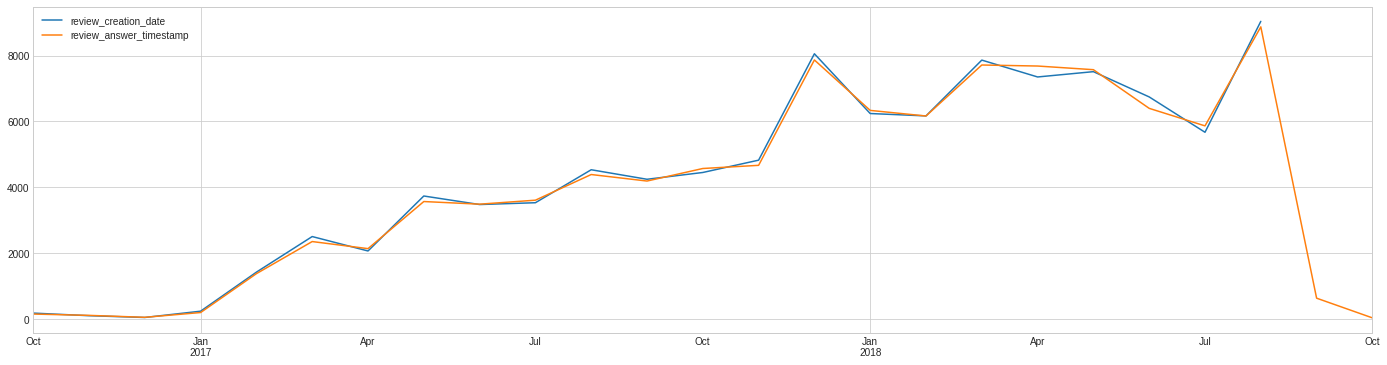

In [0]:
ax=dfReviews['review_creation_date'].value_counts().resample('M').sum().plot.line()
dfReviews['review_answer_timestamp'].value_counts().resample('M').sum().plot.line(ax=ax)
ax.legend(['review_creation_date','review_answer_timestamp'])

In [0]:
dfReviews[['review_creation_date','review_score']].set_index('review_creation_date').resample('M').mean()

,review_score
review_creation_date,
2016-10-31,4.033149
2016-11-30,3.166667
2016-12-31,2.270833
2017-01-31,4.338912
2017-02-28,4.269663
2017-03-31,4.012774
2017-04-30,4.025641
2017-05-31,4.086456
2017-06-30,4.109290


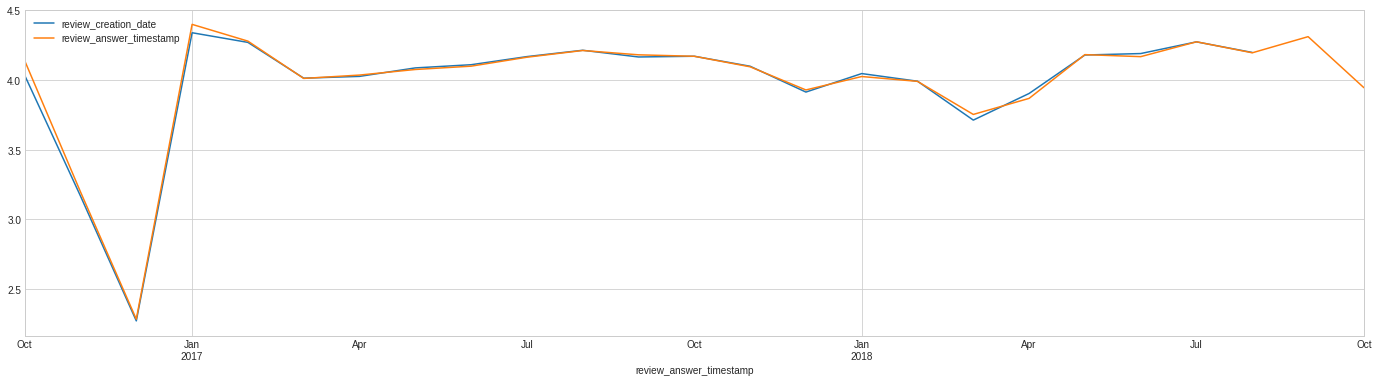

In [0]:
ax=dfReviews[['review_creation_date','review_score']].set_index('review_creation_date').resample('M').mean().plot.line()
dfReviews[['review_answer_timestamp','review_score']].set_index('review_answer_timestamp').resample('M').mean().plot.line(ax=ax)
ax.legend(['review_creation_date','review_answer_timestamp'])

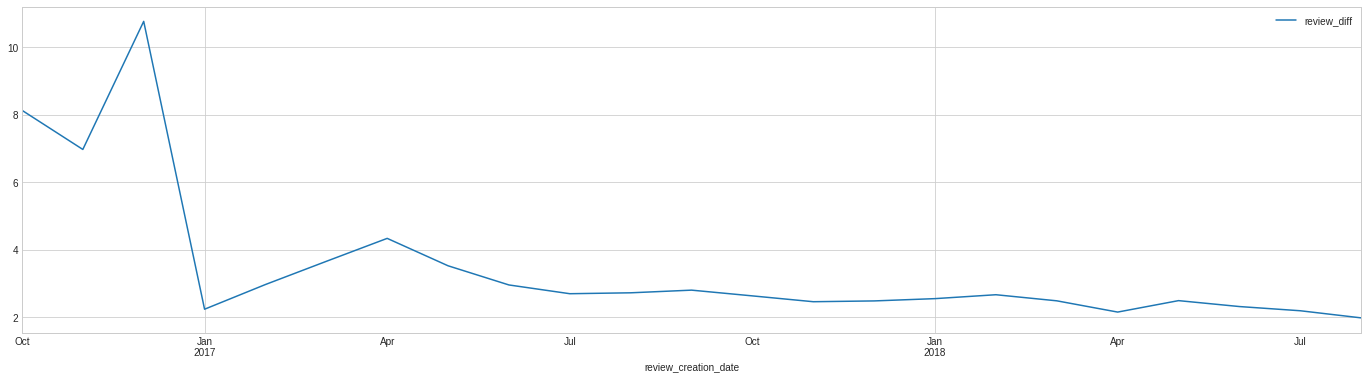

In [0]:
dfReviews1[['review_creation_date','review_diff']].set_index('review_creation_date').resample('M').mean().plot.line()

#### Cleaning

1. Converted shipping_limit_date feature from object type to datetime type

#### Interesting Insights
1. The reviews in average started with descending trend and hit it's lowest score in December 2016 along with the least number of reviews in the dataset. The descending tren ended in Janury 2017 and ascending spikes occured in the next 3 months. Eversince, the average number of reviews in the dataset constanty increases

### Items Dataset
#### Features in Items Dataset

1. order_id = Order ID corresponding to the item in the dataset (this is the primary key for merging)
2. order_item_id = Sequence of appearence for the corresponding order_id
3. product_id = ID of the product in the dataset
4. seller_id = ID of the item seller in the dataset
5. shipping_limit_date = the latest acceptable date for item delivery
6. price = price of the item being delivered
7. freight_value = value of the item being delivered

In [0]:
dfItems.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [0]:
dfItems.shape

(112650, 7)

In [0]:
resumetable(dfItems)

,dataType,null,nullPct,unique,mostValue_1,mostValueCount_1,mostValue_2,mostValueCount_2,mostValue_3,mostValueCount_3,leastValue_1,leastValueCount_1,leastValue_2,leastValueCount_2,leastValue_3,leastValueCount_3
dataFeatures,,,,,,,,,,,,,,,,
order_id,object,0,0.0,98666,8272b63d03f5f79c56e9e4120aec44ef,21.0,1b15974a0141d54e36626dca3fdc731a,20.0,ab14fdcfbe524636d65ee38360e22ce8,20.0,d36c084b5daf9cfc67fb1164f2c2bd0b,1.0,81fff738e05d97b97be744936e7535a7,1.0,6cadbcdea4da5368c7a801ce027f23f1,1.0
order_item_id,int64,0,0.0,21,1,98666.0,2,9803.0,3,2287.0,21,1.0,19,3.0,18,3.0
product_id,object,0,0.0,32951,aca2eb7d00ea1a7b8ebd4e68314663af,527.0,99a4788cb24856965c36a24e339b6058,488.0,422879e10f46682990de24d770e7f83d,484.0,5e55f49fd372a399eda3e1888157c8f3,1.0,62ea504fcbda5b4dd1069fc15e8dde79,1.0,2284b28ca179d66957a67ef01a5b7d6c,1.0
seller_id,object,0,0.0,3095,6560211a19b47992c3666cc44a7e94c0,2033.0,4a3ca9315b744ce9f8e9374361493884,1987.0,1f50f920176fa81dab994f9023523100,1931.0,a4fc6eadaff1576af888509a53420f6a,1.0,101921376b577a4540dc30e9009133ca,1.0,422be4cc81a457fdb46f47edeb968ae5,1.0
shipping_limit_date,object,0,0.0,93318,2017-07-21 18:25:23,21.0,2018-03-01 02:50:48,21.0,2017-08-30 14:30:23,20.0,2017-11-30 19:54:36,1.0,2017-11-21 04:26:33,1.0,2018-02-01 22:11:31,1.0
price,float64,0,0.0,5968,59.9,2481.0,69.9,1987.0,49.9,1953.0,618.9,1.0,117.97,1.0,1244,1.0
freight_value,float64,0,0.0,6999,15.1,3707.0,7.78,2262.0,14.1,1875.0,115.77,1.0,2.02,1.0,108.85,1.0


In [0]:
dfItems['shipping_limit_date']=pd.to_datetime(dfItems['shipping_limit_date'])
resumetable(dfItems)

,dataType,null,nullPct,unique,mostValue_1,mostValueCount_1,mostValue_2,mostValueCount_2,mostValue_3,mostValueCount_3,leastValue_1,leastValueCount_1,leastValue_2,leastValueCount_2,leastValue_3,leastValueCount_3
dataFeatures,,,,,,,,,,,,,,,,
order_id,object,0,0.0,98666,8272b63d03f5f79c56e9e4120aec44ef,21.0,1b15974a0141d54e36626dca3fdc731a,20.0,ab14fdcfbe524636d65ee38360e22ce8,20.0,d36c084b5daf9cfc67fb1164f2c2bd0b,1.0,81fff738e05d97b97be744936e7535a7,1.0,6cadbcdea4da5368c7a801ce027f23f1,1.0
order_item_id,int64,0,0.0,21,1,98666.0,2,9803.0,3,2287.0,21,1.0,19,3.0,18,3.0
product_id,object,0,0.0,32951,aca2eb7d00ea1a7b8ebd4e68314663af,527.0,99a4788cb24856965c36a24e339b6058,488.0,422879e10f46682990de24d770e7f83d,484.0,5e55f49fd372a399eda3e1888157c8f3,1.0,62ea504fcbda5b4dd1069fc15e8dde79,1.0,2284b28ca179d66957a67ef01a5b7d6c,1.0
seller_id,object,0,0.0,3095,6560211a19b47992c3666cc44a7e94c0,2033.0,4a3ca9315b744ce9f8e9374361493884,1987.0,1f50f920176fa81dab994f9023523100,1931.0,a4fc6eadaff1576af888509a53420f6a,1.0,101921376b577a4540dc30e9009133ca,1.0,422be4cc81a457fdb46f47edeb968ae5,1.0
shipping_limit_date,datetime64[ns],0,0.0,93318,2018-03-01 02:50:48,21.0,2017-07-21 18:25:23,21.0,2017-08-30 14:30:23,20.0,2017-07-20 03:25:19,1.0,2017-12-07 18:25:31,1.0,2018-05-14 03:31:05,1.0
price,float64,0,0.0,5968,59.9,2481.0,69.9,1987.0,49.9,1953.0,618.9,1.0,117.97,1.0,1244,1.0
freight_value,float64,0,0.0,6999,15.1,3707.0,7.78,2262.0,14.1,1875.0,115.77,1.0,2.02,1.0,108.85,1.0


In [0]:
dfItems.describe()

,order_item_id,price,freight_value
count,112650.000000,112650.000000,112650.000000
mean,1.197834,120.653739,19.990320
std,0.705124,183.633928,15.806405
min,1.000000,0.850000,0.000000
25%,1.000000,39.900000,13.080000
50%,1.000000,74.990000,16.260000
75%,1.000000,134.900000,21.150000
max,21.000000,6735.000000,409.680000


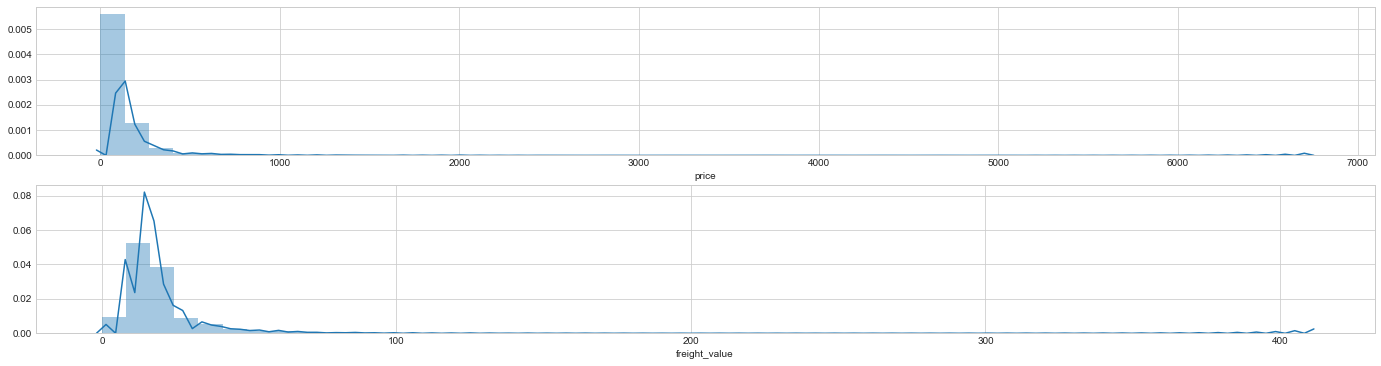

In [0]:
fig,axes=plt.subplots(2,1,figsize=(24,6))
sns.distplot(dfItems['price'],ax=axes[0])
sns.distplot(dfItems['freight_value'],ax=axes[1])

In [0]:
dfItems.iloc[:,-2:].corr()

,price,freight_value
price,1.000000,0.414204
freight_value,0.414204,1.000000


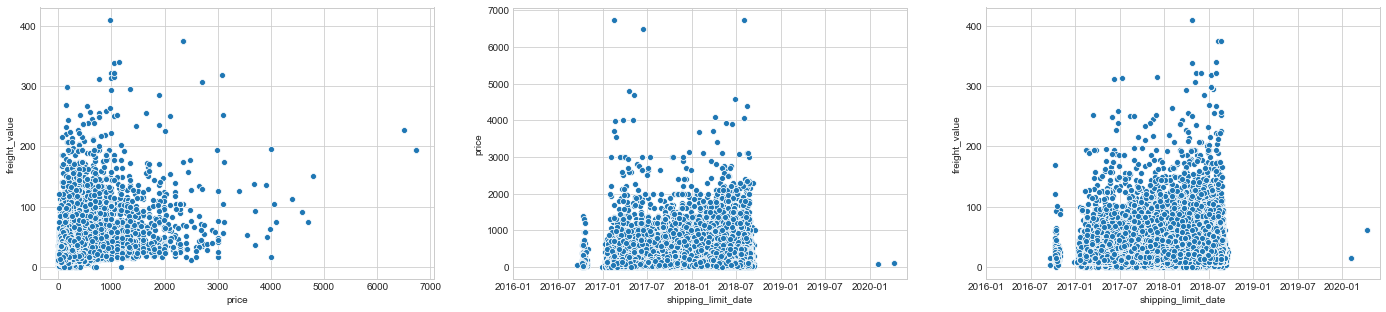

In [0]:
fig,axes=plt.subplots(1,3,figsize=(24,5))
for ax,col1,col2 in zip(axes,['price','shipping_limit_date','shipping_limit_date'],['freight_value','price','freight_value']):
    sns.scatterplot(col1,col2,data=dfItems,ax=ax)
    if col1=='shipping_limit_date':
        ax.set_xlim(pd.Timestamp(2015,12,30),pd.Timestamp(2020,6,1))

In [0]:
resumetable(dfItems)

,dataType,null,nullPct,unique,mostValue_1,mostValueCount_1,mostValue_2,mostValueCount_2,mostValue_3,mostValueCount_3,leastValue_1,leastValueCount_1,leastValue_2,leastValueCount_2,leastValue_3,leastValueCount_3
dataFeatures,,,,,,,,,,,,,,,,
order_id,object,0,0.0,98666,8272b63d03f5f79c56e9e4120aec44ef,21.0,1b15974a0141d54e36626dca3fdc731a,20.0,ab14fdcfbe524636d65ee38360e22ce8,20.0,d36c084b5daf9cfc67fb1164f2c2bd0b,1.0,81fff738e05d97b97be744936e7535a7,1.0,6cadbcdea4da5368c7a801ce027f23f1,1.0
order_item_id,int64,0,0.0,21,1,98666.0,2,9803.0,3,2287.0,21,1.0,19,3.0,18,3.0
product_id,object,0,0.0,32951,aca2eb7d00ea1a7b8ebd4e68314663af,527.0,99a4788cb24856965c36a24e339b6058,488.0,422879e10f46682990de24d770e7f83d,484.0,5e55f49fd372a399eda3e1888157c8f3,1.0,62ea504fcbda5b4dd1069fc15e8dde79,1.0,2284b28ca179d66957a67ef01a5b7d6c,1.0
seller_id,object,0,0.0,3095,6560211a19b47992c3666cc44a7e94c0,2033.0,4a3ca9315b744ce9f8e9374361493884,1987.0,1f50f920176fa81dab994f9023523100,1931.0,a4fc6eadaff1576af888509a53420f6a,1.0,101921376b577a4540dc30e9009133ca,1.0,422be4cc81a457fdb46f47edeb968ae5,1.0
shipping_limit_date,datetime64[ns],0,0.0,93318,2018-03-01 02:50:48,21.0,2017-07-21 18:25:23,21.0,2017-08-30 14:30:23,20.0,2017-07-20 03:25:19,1.0,2017-12-07 18:25:31,1.0,2018-05-14 03:31:05,1.0
price,float64,0,0.0,5968,59.9,2481.0,69.9,1987.0,49.9,1953.0,618.9,1.0,117.97,1.0,1244,1.0
freight_value,float64,0,0.0,6999,15.1,3707.0,7.78,2262.0,14.1,1875.0,115.77,1.0,2.02,1.0,108.85,1.0


In [0]:
dfItems['order_id'].value_counts().head(10)

8272b63d03f5f79c56e9e4120aec44ef    21
1b15974a0141d54e36626dca3fdc731a    20
ab14fdcfbe524636d65ee38360e22ce8    20
428a2f660dc84138d969ccd69a0ab6d5    15
9ef13efd6949e4573a18964dd1bbe7f5    15
9bdc4d4c71aa1de4606060929dee888c    14
73c8ab38f07dc94389065f7eba4f297a    14
37ee401157a3a0b28c9c6d0ed8c3b24b    13
af822dacd6f5cff7376413c03a388bb7    12
c05d6a79e55da72ca780ce90364abed9    12
Name: order_id, dtype: int64

In [0]:
dfItems[dfItems['order_id']=='8272b63d03f5f79c56e9e4120aec44ef']

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
57297,8272b63d03f5f79c56e9e4120aec44ef,1,270516a3f41dc035aa87d220228f844c,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57298,8272b63d03f5f79c56e9e4120aec44ef,2,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57299,8272b63d03f5f79c56e9e4120aec44ef,3,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57300,8272b63d03f5f79c56e9e4120aec44ef,4,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57301,8272b63d03f5f79c56e9e4120aec44ef,5,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57302,8272b63d03f5f79c56e9e4120aec44ef,6,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57303,8272b63d03f5f79c56e9e4120aec44ef,7,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57304,8272b63d03f5f79c56e9e4120aec44ef,8,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57305,8272b63d03f5f79c56e9e4120aec44ef,9,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57306,8272b63d03f5f79c56e9e4120aec44ef,10,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89


In [0]:
dfItems[dfItems['order_id']=='1b15974a0141d54e36626dca3fdc731a']

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
11932,1b15974a0141d54e36626dca3fdc731a,1,ee3d532c8a438679776d222e997606b3,8e6d7754bc7e0f22c96d255ebda59eba,2018-03-01 02:50:48,100.0,10.12
11933,1b15974a0141d54e36626dca3fdc731a,2,ee3d532c8a438679776d222e997606b3,8e6d7754bc7e0f22c96d255ebda59eba,2018-03-01 02:50:48,100.0,10.12
11934,1b15974a0141d54e36626dca3fdc731a,3,ee3d532c8a438679776d222e997606b3,8e6d7754bc7e0f22c96d255ebda59eba,2018-03-01 02:50:48,100.0,10.12
11935,1b15974a0141d54e36626dca3fdc731a,4,ee3d532c8a438679776d222e997606b3,8e6d7754bc7e0f22c96d255ebda59eba,2018-03-01 02:50:48,100.0,10.12
11936,1b15974a0141d54e36626dca3fdc731a,5,ee3d532c8a438679776d222e997606b3,8e6d7754bc7e0f22c96d255ebda59eba,2018-03-01 02:50:48,100.0,10.12
11937,1b15974a0141d54e36626dca3fdc731a,6,ee3d532c8a438679776d222e997606b3,8e6d7754bc7e0f22c96d255ebda59eba,2018-03-01 02:50:48,100.0,10.12
11938,1b15974a0141d54e36626dca3fdc731a,7,ee3d532c8a438679776d222e997606b3,8e6d7754bc7e0f22c96d255ebda59eba,2018-03-01 02:50:48,100.0,10.12
11939,1b15974a0141d54e36626dca3fdc731a,8,ee3d532c8a438679776d222e997606b3,8e6d7754bc7e0f22c96d255ebda59eba,2018-03-01 02:50:48,100.0,10.12
11940,1b15974a0141d54e36626dca3fdc731a,9,ee3d532c8a438679776d222e997606b3,8e6d7754bc7e0f22c96d255ebda59eba,2018-03-01 02:50:48,100.0,10.12
11941,1b15974a0141d54e36626dca3fdc731a,10,ee3d532c8a438679776d222e997606b3,8e6d7754bc7e0f22c96d255ebda59eba,2018-03-01 02:50:48,100.0,10.12


In [0]:
dfItems['product_id'].value_counts().head(10)

aca2eb7d00ea1a7b8ebd4e68314663af    527
99a4788cb24856965c36a24e339b6058    488
422879e10f46682990de24d770e7f83d    484
389d119b48cf3043d311335e499d9c6b    392
368c6c730842d78016ad823897a372db    388
53759a2ecddad2bb87a079a1f1519f73    373
d1c427060a0f73f6b889a5c7c61f2ac4    343
53b36df67ebb7c41585e8d54d6772e08    323
154e7e31ebfa092203795c972e5804a6    281
3dd2a17168ec895c781a9191c1e95ad7    274
Name: product_id, dtype: int64

In [0]:
dfItems['seller_id'].value_counts()

6560211a19b47992c3666cc44a7e94c0    2033
4a3ca9315b744ce9f8e9374361493884    1987
1f50f920176fa81dab994f9023523100    1931
cc419e0650a3c5ba77189a1882b7556a    1775
da8622b14eb17ae2831f4ac5b9dab84a    1551
955fee9216a65b617aa5c0531780ce60    1499
1025f0e2d44d7041d6cf58b6550e0bfa    1428
7c67e1448b00f6e969d365cea6b010ab    1364
ea8482cd71df3c1969d7b9473ff13abc    1203
7a67c85e85bb2ce8582c35f2203ad736    1171
4869f7a5dfa277a7dca6462dcf3b52b2    1156
3d871de0142ce09b7081e2b9d1733cb1    1147
8b321bb669392f5163d04c59e235e066    1018
cca3071e3e9bb7d12640c9fbe2301306     830
620c87c171fb2a6dd6e8bb4dec959fc6     798
a1043bafd471dff536d0c462352beb48     770
e9779976487b77c6d4ac45f75ec7afe9     750
f8db351d8c4c4c22c6835c19a46f01b0     724
d2374cbcbb3ca4ab1086534108cc3ab7     631
391fc6631aebcf3004804e51b40bcf1e     613
fa1c13f2614d7b5c4749cbc52fecda94     586
7d13fca15225358621be4086e1eb0964     578
128639473a139ac0f3e5f5ade55873a5     560
1835b56ce799e6a4dc4eddc053f04066     558
46dc3b2cc0980fb8

In [0]:
top3_products_count=pd.DataFrame(dfItems['product_id'].value_counts())
for i in range(0,20,1):
    top3_products_count[f'seller#{i+1}']=dfItems[dfItems['seller_id']==(dfItems['seller_id'].value_counts().index[i])]['product_id'].value_counts()
top3_products_count.reset_index().rename(columns={'product_id':'all_seller','index':'product_id'}).head(25)

,product_id,all_seller,seller#1,seller#2,seller#3,seller#4,seller#5,seller#6,seller#7,seller#8,seller#9,seller#10,seller#11,seller#12,seller#13,seller#14,seller#15,seller#16,seller#17,seller#18,seller#19,seller#20
0,aca2eb7d00ea1a7b8ebd4e68314663af,527,NaN,NaN,NaN,NaN,NaN,527.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,99a4788cb24856965c36a24e339b6058,488,NaN,482.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,422879e10f46682990de24d770e7f83d,484,NaN,NaN,484.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,389d119b48cf3043d311335e499d9c6b,392,NaN,NaN,392.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,368c6c730842d78016ad823897a372db,388,NaN,NaN,388.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,53759a2ecddad2bb87a079a1f1519f73,373,NaN,NaN,373.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,d1c427060a0f73f6b889a5c7c61f2ac4,343,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,343.0,NaN,NaN,NaN,NaN
7,53b36df67ebb7c41585e8d54d6772e08,323,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,106.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,154e7e31ebfa092203795c972e5804a6,281,NaN,NaN,NaN,281.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,3dd2a17168ec895c781a9191c1e95ad7,274,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
dfItems[dfItems['seller_id']=='6560211a19b47992c3666cc44a7e94c0']['product_id'].value_counts()

a92930c327948861c015c919a0bcb4a8    160
d017a2151d543a9885604dc62a3d9dcc    140
2136c70bbe723d338fab53da3c03e6dc     89
c3ba4e8d3cb30049213b682e751e9d00     58
dc52f0f5d3ec37a93eaf956cde4e5d2c     39
1600dcf1cea8c0c83702e07b577ab231     38
57f2bc497c1a3ebe41ba7a06d78ed159     38
380b4664ba5bb18cc9db78ee6bac3558     36
186fe07c8b8005ec6a498587ffbc1352     36
aa8d88eb4b9cb38894e33fa624c4287f     33
44d097d59e8430f88a67517cd0c4f865     31
5403528d987ad26e8d7cb25940411987     29
e2bb00220a167d9e60b6776ac33717bc     29
dca8cbb1c9d8a2db0fbc0c36b8d1a7bc     29
86c43103446290e7efacad3701cd654d     28
7f064525eaaa1ce9d22c085f7ff5413a     25
c708ba7c6269161f89ce0683cdd7c432     24
b84520a57891e7a8ae2c68741dcc7146     24
e06f99e79036d681effa3de75989bf22     24
5d7c23067ed3fc8c6e699b9373d5890b     23
5c692818d313aa12864b48ac0c2472c2     22
87cb507e0daa37bbf34956fd59eba832     22
423b46d7ff817b1cd19ab195c7b76546     21
7703b8cb5b77fbb36518ea91e2ca734f     21
9c7ce59c96e74dfdfc51f13a4a6c3869     19


In [0]:
top3_products_count=pd.DataFrame(dfItems['product_id'].value_counts())
for i in range(0,20,1):
    top3_products_count[f'order#{i+1}']=dfItems[dfItems['order_id']==(dfItems['order_id'].value_counts().index[i])]['product_id'].value_counts()
top3_products_count.reset_index().rename(columns={'product_id':'all_orders','index':'product_id'}).head(25)

,product_id,all_orders,order#1,order#2,order#3,order#4,order#5,order#6,order#7,order#8,order#9,order#10,order#11,order#12,order#13,order#14,order#15,order#16,order#17,order#18,order#19,order#20
0,aca2eb7d00ea1a7b8ebd4e68314663af,527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,99a4788cb24856965c36a24e339b6058,488,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,422879e10f46682990de24d770e7f83d,484,NaN,NaN,NaN,NaN,NaN,NaN,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,389d119b48cf3043d311335e499d9c6b,392,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,368c6c730842d78016ad823897a372db,388,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,53759a2ecddad2bb87a079a1f1519f73,373,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN
6,d1c427060a0f73f6b889a5c7c61f2ac4,343,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,53b36df67ebb7c41585e8d54d6772e08,323,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,154e7e31ebfa092203795c972e5804a6,281,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,3dd2a17168ec895c781a9191c1e95ad7,274,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Cleaning
1. Changed review_creation_date and review_answer_timestamp features type from object to datetime

#### Interesting Insights

1. Almost every items sold in the top most sold item is monopolized by particular sellers.
2. Higher price doesn't has any impact on freight value.

## Dataset Dump
Dataset is dumped to be analysed further on another notebook

In [0]:
def check_row_names():
    dupes=[]
    pks=['order_id','customer_id','product_id','seller_id','zip_code_prefix']
    print('%s shape is %s'%('product_category_translate',product_category_translate.shape))
    for name_1,df_1 in zip(dataframes,dfs):
        print('%s shape is %s'%(name_1,df_1.shape))
        for name_2,df_2 in zip(dataframes,dfs):
            if list(df_1.columns)!=list(df_2.columns):
                for col_1 in df_1.columns:
                    for col_2 in df_2.columns:
                        if col_1==col_2 and col_1 not in pks:
                            dupes.append(col_1)
                if len(dupes)>0:
                    print('%s and %s has duplicate columns names, the duplicates are listed below.'%(name_1,name_2))
                    print(dupes)
            dupes=[]

    print('Finished checking for duplicate columns.')
check_row_names()

product_category_translate shape is (71, 2)
dfItems shape is (112650, 7)
dfOrders shape is (99441, 8)
dfPayments shape is (103886, 5)
dfProducts shape is (32951, 9)
dfReviews shape is (100000, 7)
Finished checking for duplicate columns.


In [0]:
for name,df in zip(dataframes,dfs):
    pickle.dump(df,open(f'pkl_{name}.csv','wb'))